In [1]:
import os
import sys
from collections import defaultdict, Counter
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from Bio import SeqIO

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor
from pymutspec.constants import possible_sbs192, possible_sbs12

#### merge cytb of spretus and musculus

In [18]:
def read_mapping(fn) -> dict:
    with open(fn) as fin:
        lines = [x.strip() for x in fin.readlines()]
        assert len(lines) % 2 == 0
        mapping = dict(zip(lines[::2], lines[1::2]))
    return mapping


musculus_seqs = [x for x in SeqIO.parse("../data/selection_search/mouse_cytb/sequences/seqs_unique.fasta", "fasta")]
spretus_seqs =  [x for x in SeqIO.parse("../data/selection_search/spretus_cytb/sequences/seqs_unique.fasta", "fasta")]

musculus_mapping = read_mapping("../data/selection_search/mouse_cytb/sequences/headers_mapping.txt")
spretus_mapping  = read_mapping("../data/selection_search/spretus_cytb/sequences/headers_mapping.txt")

In [19]:
for rec in musculus_seqs:
    rec.id = ""
    rec.description = musculus_mapping[rec.description]

for rec in spretus_seqs:
    rec.id = ""
    rec.description = spretus_mapping[rec.description]

In [20]:
SeqIO.write(spretus_seqs, "../bla.fasta", "fasta-2line")

183

## Load data species-gene specific

In [3]:
mouse_cytb = dict()
mouse_cox1 = dict()
mouse_nd1 = dict()
human_cytb = dict()
human_cox1 = dict()
human_nd1 = dict()


def get_consensus(aln):
    seq = []
    for column in zip(*aln):
        nuc = Counter(column).most_common()[0][0]
        seq.append(nuc)
    return "".join(seq)


for dct, gene in zip(
        [mouse_cytb, mouse_cox1, mouse_nd1, human_cytb, human_cox1, human_nd1], 
        ["mouse_cytb", "mouse_cox1", "mouse_nd1", "human_cytb", "human_cox1", "human_nd1"]
    ):
    indir = f"../data/selection_search/{gene}/"

    dct["aln"] = [str(x.seq) for x in SeqIO.parse(indir + "sequences/alignment_checked.fasta", format="fasta")]
    dct["mutations"] = pd.read_csv(indir + "tables/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")
    dct["exp_muts"]  = pd.read_csv(indir + "exp_muts_invariant.tsv", sep="\t").set_index("Mut").Count.to_dict()
    dct["rate"] = pd.read_csv(f"../data/selection_search/rates/{gene}.rate", sep="\t", comment="#")
    dct["rate"]["Site"] = np.arange(dct["rate"].shape[0]) + 1
    dct["var_pos"] = dct["rate"][dct["rate"]["Cat"] > 1]["Site"].values
    dct["consensus"] = get_consensus(dct["aln"])

    assert len(dct["rate"]) == len(dct["consensus"])


    dct["ms_rec192"] = pd.read_csv(indir + f"ms/ms192syn_internal_{gene}.tsv", sep="\t")
    dct["ms_rec12"]  = pd.read_csv(indir + f"ms/ms12syn_internal_{gene}.tsv", sep="\t")
    dct["ms_sim192"] = pd.read_csv(indir + f"pyvolve/out/ms192syn_{gene}_internal_simulated.tsv", sep="\t")
    dct["ms_sim12"]  = pd.read_csv(indir + f"pyvolve/out/ms12syn_{gene}_internal_simulated.tsv", sep="\t")


# # turn spectra to light strand
# for data in [mouse_cytb, human_cytb, human_nd1]:  # without mus ND1, because this data are redone
#     data["ms_rec192"]["Mut"] = data["ms_rec192"]["Mut"].apply(rev_comp)
#     data["ms_rec12"]["Mut"] = data["ms_rec12"]["Mut"].str.translate(transcriptor)
#     data["ms_sim192"]["Mut"] = data["ms_sim192"]["Mut"].apply(rev_comp)

In [5]:
human_cytb["consensus"]

'ATGACCCCAATACGCAAAATTAACCCCCTAATAAAATTAATTAACCACTCATTCATCGACCTCCCCACCCCATCCAACATCTCCGCATGATGAAACTTCGGCTCACTCCTTGGCGCCTGCCTGATCCTCCAAATCACCACAGGACTATTCCTAGCCATGCACTACTCACCAGACGCCTCAACCGCCTTTTCATCAATCGCCCACATCACTCGAGACGTAAATTATGGCTGAATCATCCGCTACCTTCACGCCAATGGCGCCTCAATATTCTTTATCTGCCTCTTCCTACACATCGGGCGAGGCCTATATTACGGATCATTTCTCTACTCAGAAACCTGAAACATCGGCATTATCCTCCTGCTTGCAACTATAGCAACAGCCTTCATAGGCTATGTCCTCCCGTGAGGCCAAATATCATTCTGAGGGGCCACAGTAATTACAAACTTACTATCCGCCATCCCATACATTGGGACAGACCTAGTTCAATGAATCTGAGGAGGCTACTCAGTAGACAGTCCCACCCTCACACGATTCTTTACCTTTCACTTCATCTTGCCCTTCATTATTGCAGCCCTAGCAGCACTCCACCTCCTATTCTTGCACGAAACGGGATCAAACAACCCCCTAGGAATCACCTCCCATTCCGATAAAATCACCTTCCACCCTTACTACACAATCAAAGACGCCCTCGGCTTACTTCTCTTCCTTCTCTCCTTAATGACATTAACACTATTCTCACCAGACCTCCTAGGCGACCCAGACAATTATACCCTAGCCAACCCCTTAAACACCCCTCCCCACATCAAGCCCGAATGATATTTCCTATTCGCCTACACAATTCTCCGATCCGTCCCTAACAAACTAGGAGGCGTCCTTGCCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAACAAAGCATAATATTTCGCCCACTAAGCCAATCACTTTATTGACTCCTAGCCGCAGACCTCCTC

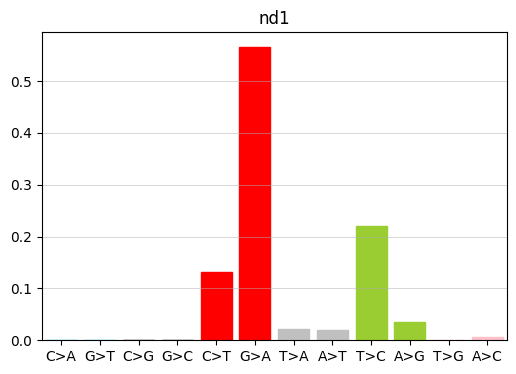

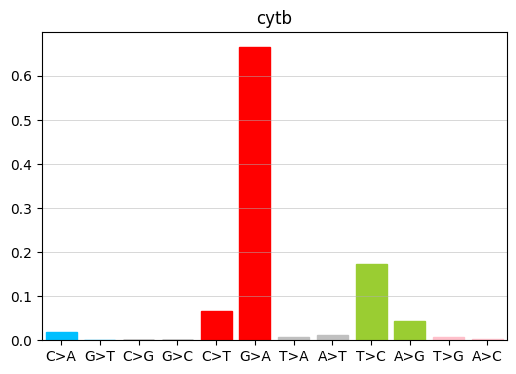

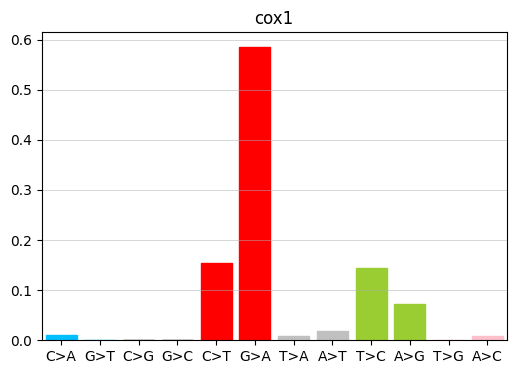

<AxesSubplot:title={'center':'cox1'}>

In [4]:
plot_mutspec12(mouse_nd1['ms_rec12'], title="nd1")
plot_mutspec12(mouse_cytb['ms_rec12'], title="cytb")
plot_mutspec12(mouse_cox1['ms_rec12'], title="cox1")

## Position Invariativity QC

### Obs mutations

In [6]:
to_concat = []
for lbl, data in zip(
        ['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
        [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]
    ):
    df = data["mutations"].merge(data['rate'], right_on="Site", left_on="PosInGene")
    df['IsTerminal'] = df.AltNode.str.startswith("RN_")
    df["Gene"] = lbl
    to_concat.append(df)
df = pd.concat(to_concat, ignore_index=True)

In [7]:
x = df[(df.ProbaFull > 0.3)].groupby(["Cat", "Gene", "Label", "AltNode", "IsTerminal"]).ProbaFull.sum().reset_index()
x

,Cat,Gene,Label,AltNode,IsTerminal,ProbaFull
0,0,human_cox1,0,Node1032,False,0.999993
1,0,human_cox1,0,Node1094,False,0.999997
2,0,human_cox1,0,Node1147,False,0.997562
3,0,human_cox1,0,Node1160,False,0.997562
4,0,human_cox1,0,Node1161,False,0.997562
...,...,...,...,...,...,...
12174,6,mouse_nd1,2,RN_67,True,0.999997
12175,6,mouse_nd1,2,RN_72,True,0.998016
12176,6,mouse_nd1,2,RN_81,True,0.999989
12177,6,mouse_nd1,2,RN_83,True,0.988434


In [8]:
x[x.Cat == 0]#.groupby("Gene").ProbaFull.sum()

,Cat,Gene,Label,AltNode,IsTerminal,ProbaFull
0,0,human_cox1,0,Node1032,False,0.999993
1,0,human_cox1,0,Node1094,False,0.999997
2,0,human_cox1,0,Node1147,False,0.997562
3,0,human_cox1,0,Node1160,False,0.997562
4,0,human_cox1,0,Node1161,False,0.997562
...,...,...,...,...,...,...
1654,0,mouse_cytb,2,Node93,False,0.992865
1655,0,mouse_cytb,2,RN_346,True,0.996471
1656,0,mouse_cytb,2,RN_369,True,0.999994
1657,0,mouse_cytb,2,RN_378,True,0.996422


In [6]:
# df[(df.Gene.str.startswith("human"))].to_csv("../data/human_mutations.csv", index=False)
# df[(df.Gene.str.startswith("mus"))].to_csv("../data/mouse_mutations.csv", index=False)

In [9]:
df[(df.Gene == "human_cytb") & (df.Cat == 0) & (df.AltNode.str.startswith("Node"))]

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,Site,Rate,Cat,C_Rate,IsTerminal
15,A[C>T]C,0,5,2,ACC,ATC,T,I,1.00000,1.000000,0.942305,Node4786,Node4787,human_cytb,5,0.28679,0,0.0,False
20,A[C>T]C,0,5,2,ACC,ATC,T,I,0.99999,0.999990,0.942718,Node4269,Node4270,human_cytb,5,0.28679,0,0.0,False
21,A[C>T]C,0,5,2,ACC,ATC,T,I,0.99999,0.999070,0.941446,Node1663,Node1664,human_cytb,5,0.28679,0,0.0,False
45,A[A>G]T,0,10,1,ATA,GTA,M,V,1.00000,1.000000,0.999562,Node1242,Node1813,human_cytb,10,0.30016,0,0.0,False
46,A[A>G]T,0,10,1,ATA,GTA,M,V,1.00000,0.999550,0.941704,Node764,Node765,human_cytb,10,0.30016,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512,A[T>C]G,0,1135,1,TGG,CGG,W,R,0.74377,0.191008,0.183856,Node1412,Node1413,human_cytb,1135,0.16886,0,0.0,False
4513,A[C>T]G,0,1135,1,CGG,TGG,R,W,0.25623,0.190428,0.183298,Node1412,Node1413,human_cytb,1135,0.16886,0,0.0,False
4514,A[T>C]G,0,1135,1,TGG,CGG,W,R,0.09530,0.086290,0.086281,Node1414,Node1415,human_cytb,1135,0.16886,0,0.0,False
4516,A[C>T]G,0,1135,1,CGG,TGG,R,W,0.90470,0.085530,0.085521,Node1414,Node1415,human_cytb,1135,0.16886,0,0.0,False


In [20]:
print(",".join(df[(df.Gene == "human_cytb") & (df.Cat == 0) & (df.AltNode.str.startswith("Node"))].AltNode.unique()))

Node3440,Node5159,Node1081,Node1742,Node5476,Node1392,Node5477,Node4423,Node4573,Node3054,Node1249,Node3590,Node1065,Node1191,Node2908,Node4047,Node3052,Node4373,Node989,Node3640,Node4078,Node4077,Node2410,Node2791,Node1341,Node1811,Node915,Node3850,Node2309,Node5620,Node3142,Node4127,Node2503,Node2904,Node3598,Node270,Node3165,Node380,Node2319,Node4627,Node271,Node379,Node1398,Node3872,Node745,Node625,Node1535,Node5591,Node1725,Node1371,Node5485,Node4230,Node4490,Node4777,Node601,Node2006,Node4613,Node1514,Node4930,Node244,Node2359,Node4295,Node1046,Node1329,Node4164,Node1190,Node2196,Node384,Node5240,Node4370,Node3761,Node3762,Node1327,Node906,Node881,Node883,Node3109,Node1431,Node4723,Node1043,Node1042,Node1044,Node3646,Node329,Node751,Node2669,Node1470,Node683,Node1050,Node3911,Node3912,Node5461,Node5529,Node4789,Node762,Node2952,Node369,Node2360,Node2592,Node4956,Node4379,Node777,Node4708,Node2185,Node1322,Node5511,Node793,Node4580,Node3635,Node3879,Node3780,Node4886,Node3937,Node

In [21]:
print(",".join(df[(df.Gene == "human_nd1") & (df.Cat == 0) & (df.AltNode.str.startswith("Node"))].AltNode.unique()))

Node746,Node745,Node1708,Node3155,Node2053,Node2885,Node1340,Node1341,Node2982,Node785,Node2250,Node2622,Node634,Node165,Node774,Node1573,Node69,Node3142,Node2276,Node1115,Node842,Node1868,Node1181,Node1108,Node1392,Node1393,Node1391,Node2021,Node885,Node884,Node886,Node2123,Node1980,Node1305,Node1491,Node2292,Node2825,Node2824,Node429,Node157,Node2182,Node2175,Node795,Node2174,Node794,Node2986,Node1883,Node1364,Node2475,Node2526,Node2572,Node2571,Node2591,Node2590,Node905,Node2829,Node1645,Node602,Node1055,Node2511,Node2090,Node2122,Node442,Node1327,Node3143,Node3144,Node2049,Node2109,Node1365,Node2227,Node1439,Node1438,Node1418,Node3032,Node858,Node1581,Node533,Node2191,Node2351,Node1672,Node916,Node920,Node3109,Node354,Node1400,Node1309,Node1035,Node814,Node1766,Node816,Node2575,Node2425,Node628,Node1379,Node1116,Node1559,Node299,Node1782,Node1746,Node1557,Node1558,Node3036,Node201,Node1568,Node1029,Node267,Node1250,Node967,Node966,Node758,Node2828,Node866


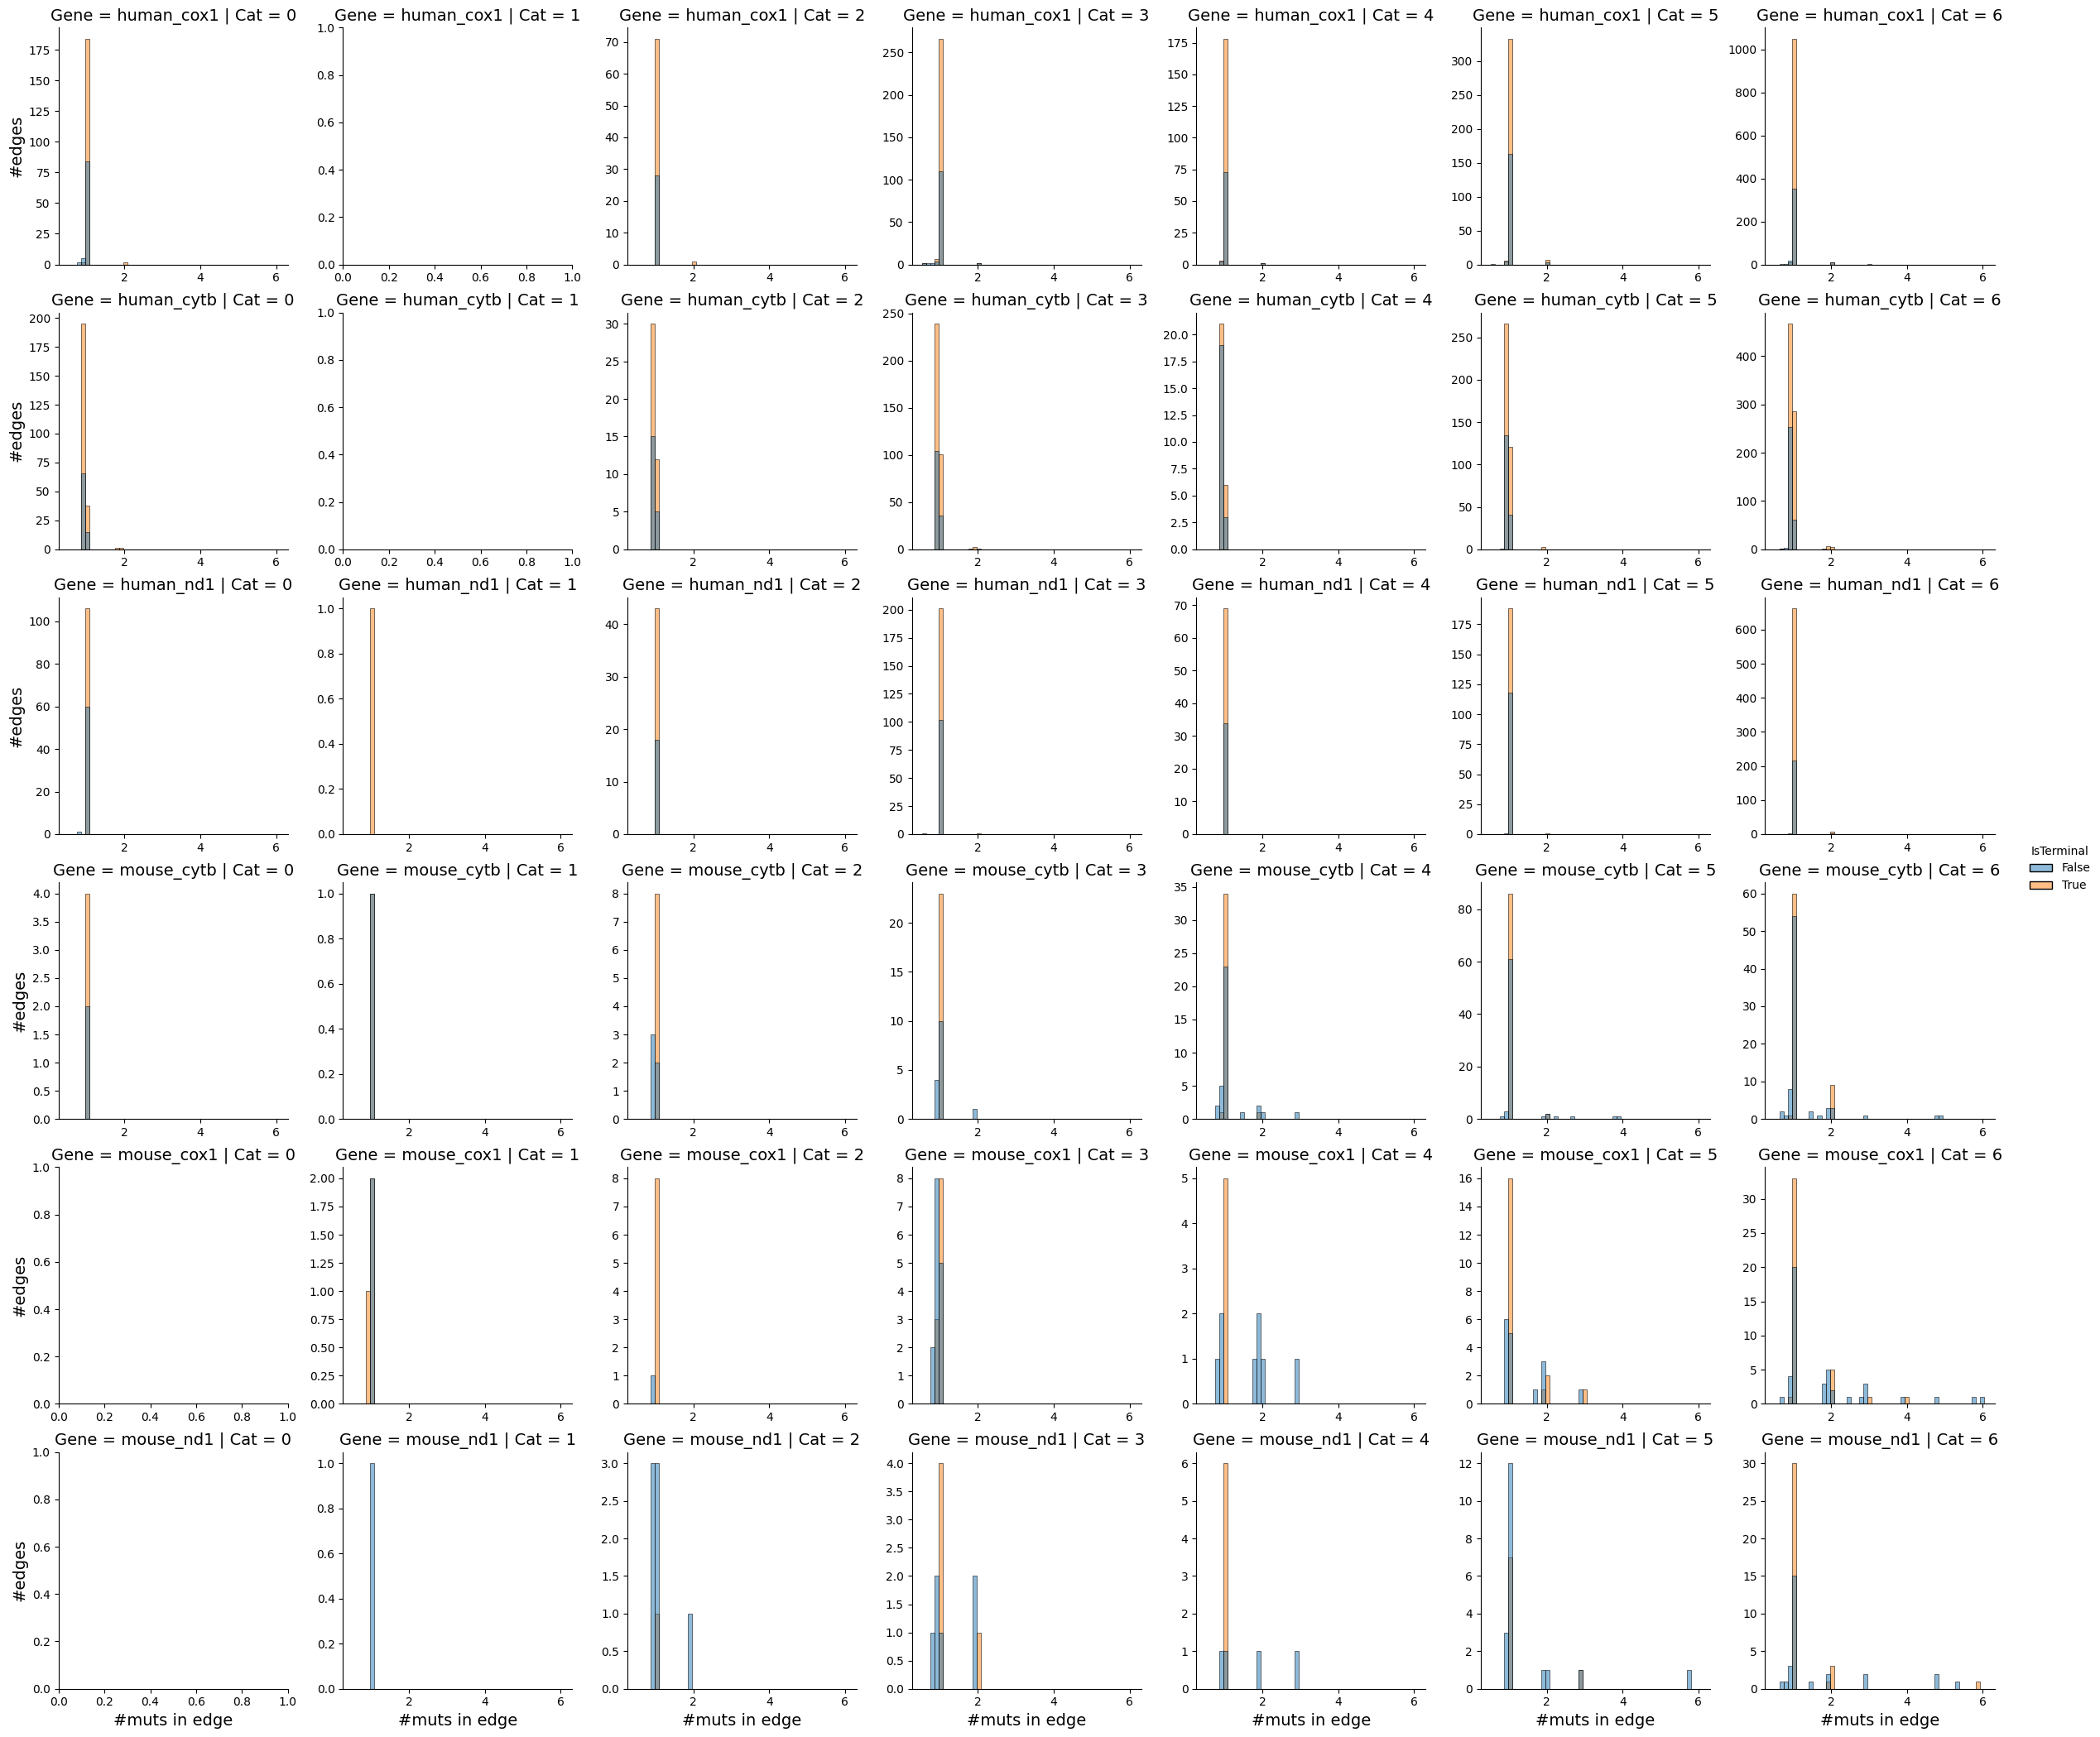

In [12]:
_df_to_plot = df[(df.ProbaFull > 0.5) & (df.Label > 0)]\
    .groupby(["Cat", "Gene", "Label", "AltNode", "IsTerminal"]).ProbaFull\
        .sum().reset_index()

g = sns.displot(
    data=_df_to_plot,
    x="ProbaFull",
    col="Cat",
    row="Gene",
    hue="IsTerminal",
    # kind="hist",
    height=3.5,
    bins=50,
    facet_kws=dict(
        sharey=False,
        sharex=False,
    )
)
g.set_axis_labels("#muts in edge", "#edges", size=14)
g.set_titles(size=14)
# plt.savefig("../figures/obs_muts_in_cats.pdf")
plt.show()

In [13]:
site_muts = df[df.ProbaFull > 0.3].groupby(["Gene", "Site", "Rate", "Cat"]).ProbaFull.sum().rename("NMuts").reset_index()
site_muts.head()

,Gene,Site,Rate,Cat,NMuts
0,human_cox1,7,3.87834,6,5.984160
1,human_cox1,8,2.59769,5,8.982964
2,human_cox1,9,0.21834,0,3.990279
3,human_cox1,10,1.27820,2,21.900765
4,human_cox1,12,2.56443,5,2.995127


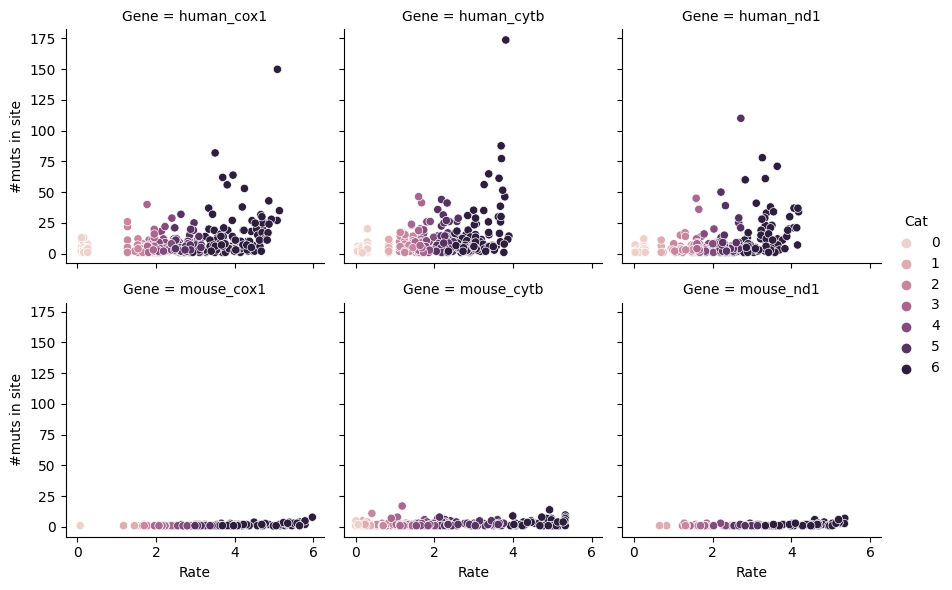

In [17]:
sns.relplot(data=site_muts, x="Rate", y="NMuts", hue="Cat",  col="Gene",col_wrap=3, sizes=(0, 160), height=3).set_axis_labels("Rate", "#muts in site")
plt.show()

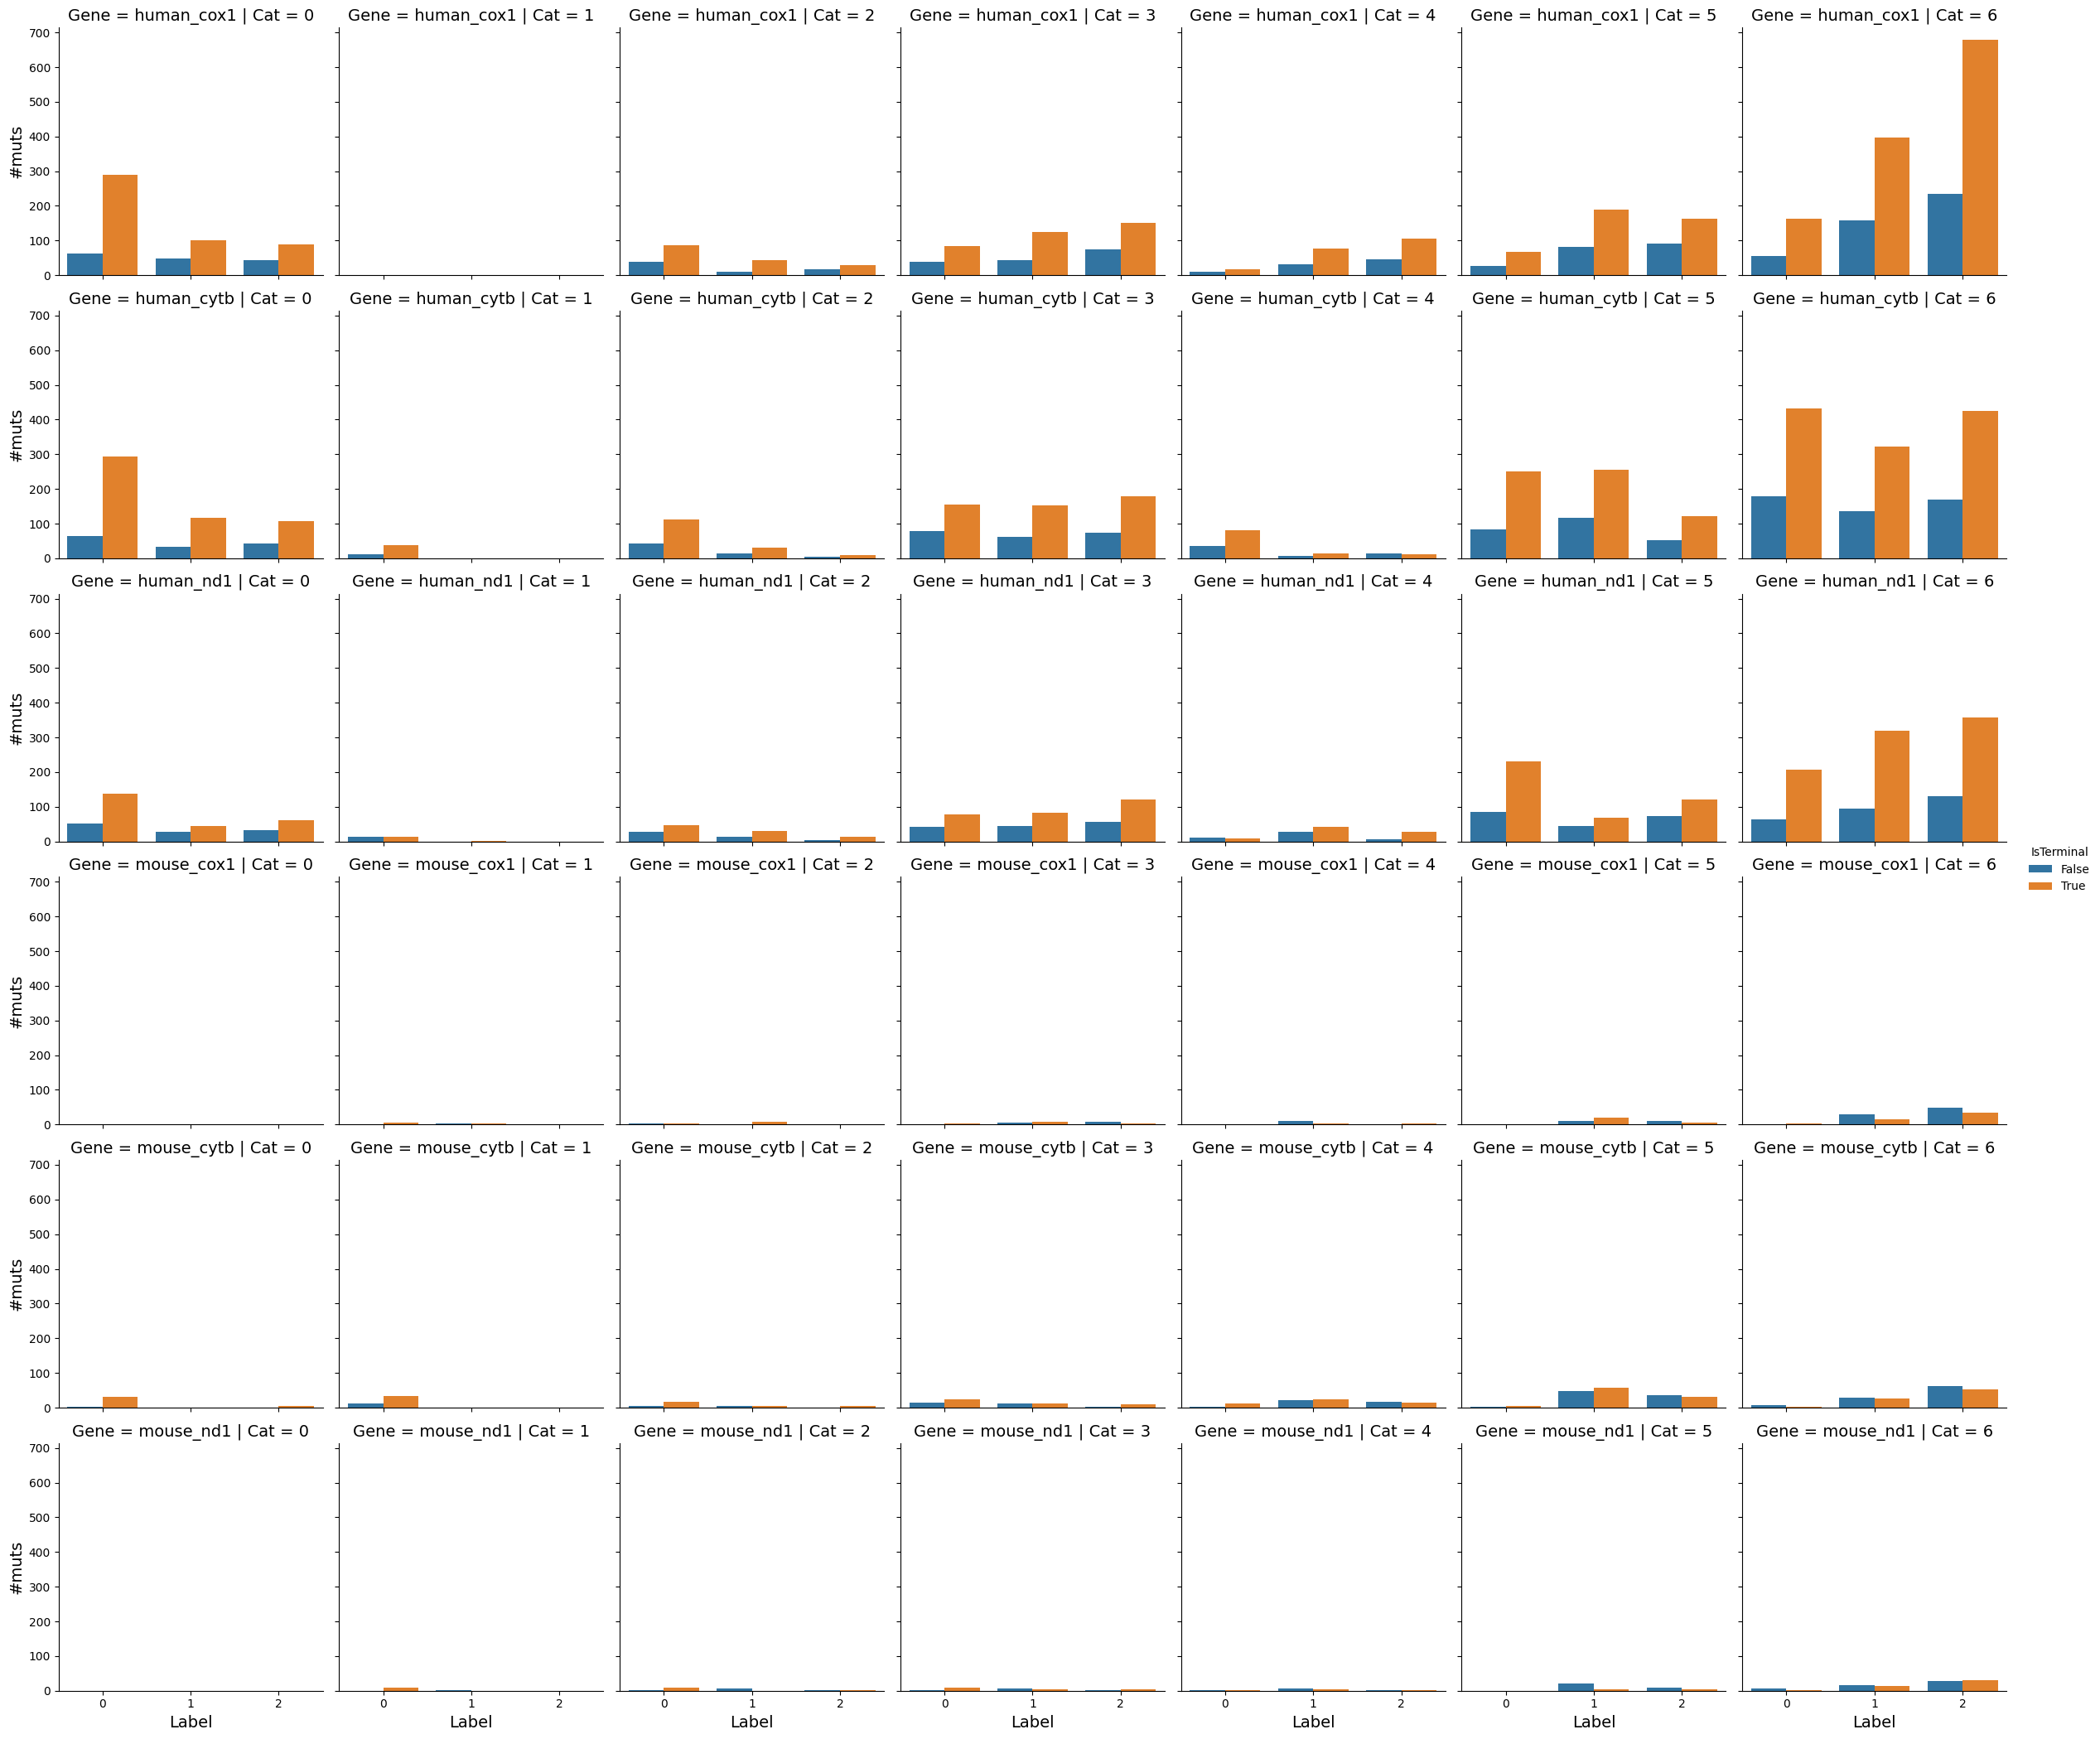

In [19]:
g = sns.catplot(
    data=df[(df.ProbaFull > 0.3)].groupby(["Cat", "Gene", "Label", "IsTerminal"]).ProbaFull.sum().reset_index(),
    x="Label",
    y="ProbaFull",
    hue="IsTerminal",
    col="Cat",
    row="Gene",
    kind="bar",
    height=3.5,
    sharey=True,
)
g.set_axis_labels("Label", "#muts", size=14)
g.set_titles(size=14)
# plt.savefig("../figures/obs_muts_in_cats.pdf")
plt.show()

### ALN

In [5]:
def get_variability_rate(aln):
    seq = []
    n = len(aln)
    for column in zip(*aln):
        m = Counter(column).most_common()[0][1]
        seq.append(m / n)
    return seq

In [ ]:
## Check 0 category of rates (it must be invariant)
for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                     [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    cats = data['rate']['Cat'].values
    vrate = get_variability_rate(data['aln'])
    print(lbl)
    assert len(cats) == len(vrate)
    for site,(c, vr) in enumerate(zip(cats, vrate), 1):
        if c == 0 and vr != 1 or c != 0 and vr == 1:
            print(f"cat = {c}, vrate = {vr:.2f} on site {site}")
    
    print()

## check strand in image

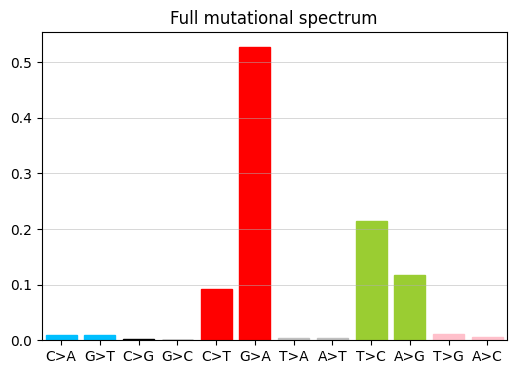

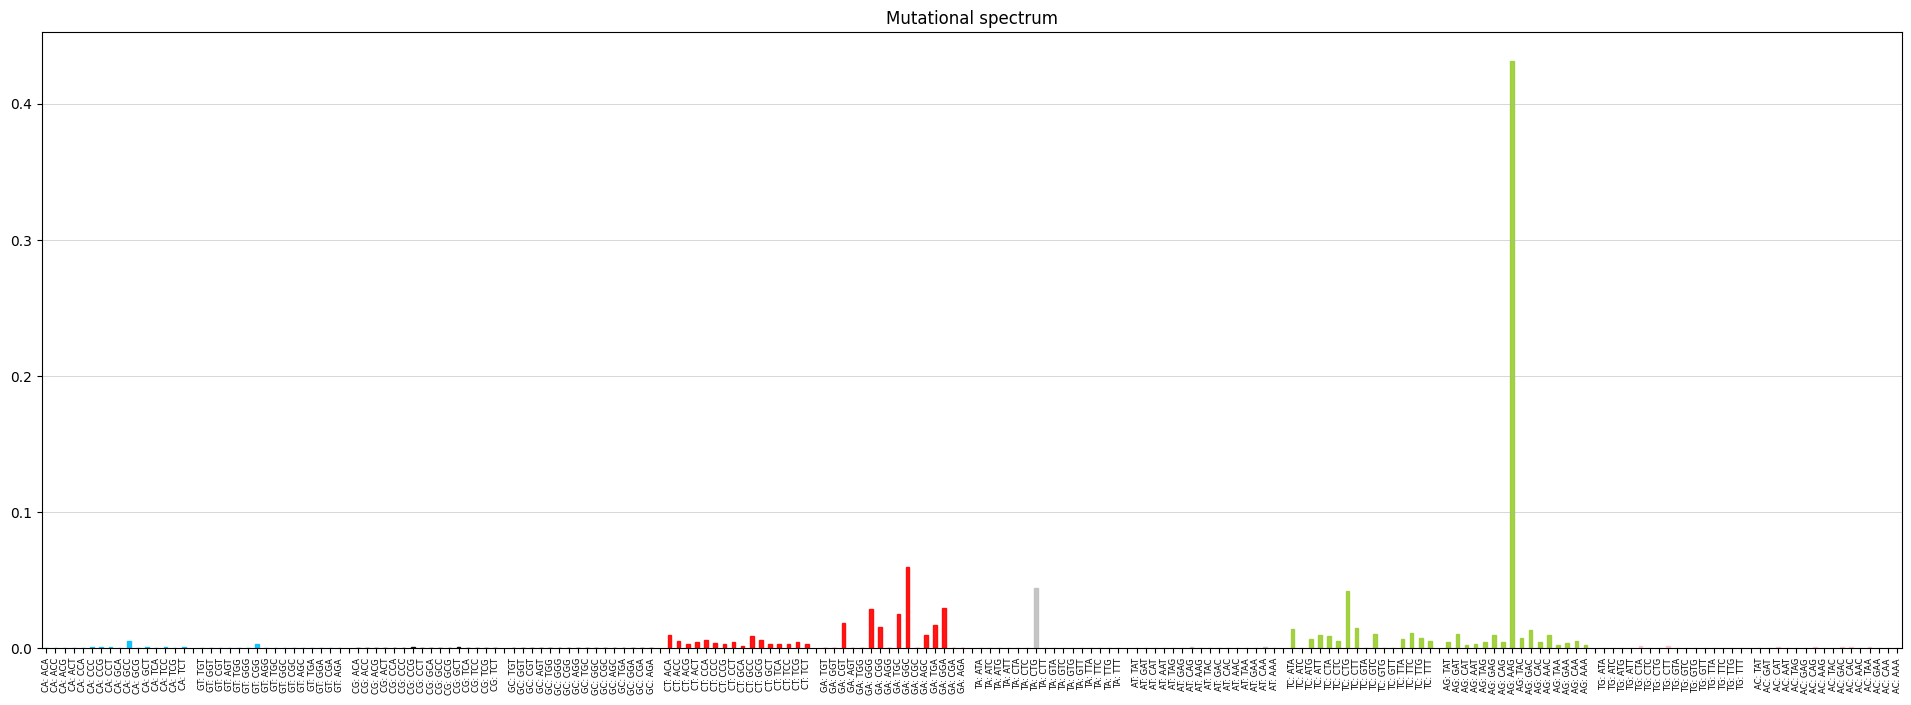

In [23]:
plot_mutspec12(human_cytb["ms_rec12"])
plot_mutspec192(human_cytb["ms_rec192"], labels_style="long")

**light**

## Estimate mutations under selection

In [44]:
def count_diff(df, nreplics=100):
    nzeros = (df.ObsNum_sim == 0).sum()
    nplus = ((df.ObsNum_rec.round() > df.ObsNum_sim) & (df.ObsNum_sim != 0)).sum()
    nminus = ((df.ObsNum_rec.round() < df.ObsNum_sim) & (df.ObsNum_sim != 0)).sum()
    n = nzeros + nplus + nminus
    n_eq = nreplics - n
    return pd.Series(dict(nzeros=nzeros, n_eq=n_eq, nplus=nplus, nminus=nminus, zerosFr=nzeros/n, plusFr=nplus/n, minusFr=nminus/n))


def get_significance(df):
    a = df.nplus.item()
    b = df.nminus.item()
    n = a + b
    if n > 5:
        pval = binom_test(a, n)
    else:
        pval = np.nan
    return pval

In [48]:
pcutoff = 0.3
nreplics=100

for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                     [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    # drop low-proba mutations from ObsNum (simple replacing)
    _ms_rec192 = data["ms_rec192"].copy()
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node"))
    ]
    high_proba_obs = high_proba_muts_syn.groupby("Mut").ProbaFull.sum().to_dict()
    _ms_rec192["ObsNum"] = _ms_rec192["Mut"].map(high_proba_obs).fillna(0.)

    # merge rec and sim
    df = _ms_rec192.merge(data["ms_sim192"], on="Mut", suffixes=["_rec", "_sim"])
    # df["diff"] = df["ObsNum_rec"] - df["ObsNum_sim"]
    data["both"] = df
    gr = df.groupby("Mut")
    
    diff_stats = gr.agg({"ObsNum_rec": "mean", "ObsNum_sim": "mean"})

    # diff_stats = gr["diff"].agg(
    #     ["mean", "std", lambda x: bootstrap((x,), np.mean).confidence_interval])
    # diff_stats["low"] = diff_stats["<lambda_0>"].apply(lambda x: x.low)
    # diff_stats["high"] = diff_stats["<lambda_0>"].apply(lambda x: x.high)
    # diff_stats.drop("<lambda_0>", axis=1, inplace=True)
    
    _diff_stats2 = gr.apply(partial(count_diff, nreplics=nreplics))
    diff_stats = diff_stats.merge(_diff_stats2, left_index=True, right_index=True)
    del _diff_stats2
    diff_stats["p-value"] = diff_stats["n_eq"] / (nreplics + 1)
    # diff_stats["p-value"] = diff_stats.apply(get_significance, axis=1)
    # diff_stats["p-value-adj"] = multipletests(diff_stats["p-value"])[1]

    data["diff_stats"] = diff_stats

    # extract sbs under selection
    # pval_cutoff = 0.15 if lbl.startswith("human") else 0.05
    pval_cutoff = 0.05
    diff_stats_filtered = diff_stats[(diff_stats["ObsNum_rec"] > 0) & (diff_stats["p-value"] < pval_cutoff) & (diff_stats["zerosFr"] < 0.95)]
    data["diff_stats_filtered"] = diff_stats_filtered
    data["muts_positive"] = diff_stats_filtered[(diff_stats_filtered["nplus"] > diff_stats_filtered["nminus"])].index.values
    data["muts_negative"] = diff_stats_filtered[(diff_stats_filtered["nplus"] < diff_stats_filtered["nminus"])].index.values


In [49]:
human_cytb["diff_stats_filtered"]

,ObsNum_rec,ObsNum_sim,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]C,14.247260,2.60,8.0,0.0,92.0,0.0,0.080000,0.920000,0.000000,0.000000
A[C>T]A,33.731001,17.04,0.0,0.0,100.0,0.0,0.000000,1.000000,0.000000,0.000000
A[C>T]T,17.017371,21.93,0.0,2.0,14.0,84.0,0.000000,0.142857,0.857143,0.019802
A[G>A]C,3.766285,21.01,0.0,0.0,0.0,100.0,0.000000,0.000000,1.000000,0.000000
A[T>C]T,31.533347,40.05,0.0,1.0,9.0,90.0,0.000000,0.090909,0.909091,0.009901
C[A>G]A,14.124593,7.51,0.0,1.0,98.0,1.0,0.000000,0.989899,0.010101,0.009901
C[A>G]C,10.304568,2.16,10.0,0.0,90.0,0.0,0.100000,0.900000,0.000000,0.000000
C[A>T]G,1.941149,0.49,59.0,4.0,35.0,2.0,0.614583,0.364583,0.020833,0.039604
C[C>T]A,21.664667,9.53,0.0,0.0,100.0,0.0,0.000000,1.000000,0.000000,0.000000


In [50]:
human_nd1["diff_stats_filtered"]

,ObsNum_rec,ObsNum_sim,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]A,5.990545,1.69,22.0,1.0,77.0,0.0,0.222222,0.777778,0.000000,0.009901
A[A>G]C,12.830338,7.28,0.0,2.0,96.0,2.0,0.000000,0.979592,0.020408,0.019802
A[C>T]A,9.986471,5.38,0.0,0.0,95.0,5.0,0.000000,0.950000,0.050000,0.000000
A[C>T]C,12.985133,2.40,13.0,0.0,87.0,0.0,0.130000,0.870000,0.000000,0.000000
A[C>T]G,8.985620,5.35,1.0,5.0,88.0,6.0,0.010526,0.926316,0.063158,0.049505
A[C>T]T,3.990459,6.42,0.0,5.0,20.0,75.0,0.000000,0.210526,0.789474,0.049505
A[G>A]C,8.956991,3.86,2.0,1.0,94.0,3.0,0.020202,0.949495,0.030303,0.009901
A[G>A]T,9.919966,4.07,4.0,1.0,95.0,0.0,0.040404,0.959596,0.000000,0.009901
A[T>C]G,9.991139,4.07,1.0,1.0,97.0,1.0,0.010101,0.979798,0.010101,0.009901


In [51]:
mouse_nd1["diff_stats_filtered"].sort_values("Mut")

,ObsNum_rec,ObsNum_sim,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[C>T]A,3.910827,0.34,74.0,0.0,26.0,0.0,0.740000,0.260000,0.0,0.000000
A[C>T]G,1.979491,0.20,81.0,1.0,18.0,0.0,0.818182,0.181818,0.0,0.009901
A[C>T]T,9.540548,0.89,41.0,0.0,59.0,0.0,0.410000,0.590000,0.0,0.000000
A[G>A]T,3.668348,0.21,80.0,0.0,20.0,0.0,0.800000,0.200000,0.0,0.000000
A[T>C]A,3.918745,0.37,69.0,0.0,31.0,0.0,0.690000,0.310000,0.0,0.000000
C[C>T]A,4.622678,0.46,63.0,0.0,37.0,0.0,0.630000,0.370000,0.0,0.000000
C[T>C]A,6.288093,1.09,30.0,0.0,70.0,0.0,0.300000,0.700000,0.0,0.000000
C[T>C]C,2.928234,0.40,64.0,0.0,36.0,0.0,0.640000,0.360000,0.0,0.000000
C[T>C]T,4.437932,0.78,44.0,1.0,55.0,0.0,0.444444,0.555556,0.0,0.009901


In [52]:
mouse_cytb["diff_stats_filtered"]

,ObsNum_rec,ObsNum_sim,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]C,2.967043,0.65,48.0,2.0,50.0,0.0,0.489796,0.510204,0.000000,0.019802
A[C>T]C,8.382723,1.28,28.0,0.0,72.0,0.0,0.280000,0.720000,0.000000,0.000000
A[G>A]C,5.920021,1.02,35.0,0.0,65.0,0.0,0.350000,0.650000,0.000000,0.000000
A[T>C]A,11.202603,2.38,10.0,0.0,90.0,0.0,0.100000,0.900000,0.000000,0.000000
A[T>C]C,2.667484,0.46,64.0,1.0,34.0,1.0,0.646465,0.343434,0.010101,0.009901
A[T>C]T,5.942638,1.64,18.0,1.0,81.0,0.0,0.181818,0.818182,0.000000,0.009901
C[A>C]T,1.992932,0.13,88.0,1.0,11.0,0.0,0.888889,0.111111,0.000000,0.009901
C[A>G]A,1.999970,0.55,52.0,5.0,42.0,1.0,0.547368,0.442105,0.010526,0.049505
C[A>G]C,2.955285,0.27,77.0,0.0,23.0,0.0,0.770000,0.230000,0.000000,0.000000


### Plot sbs under selection

human_cytb


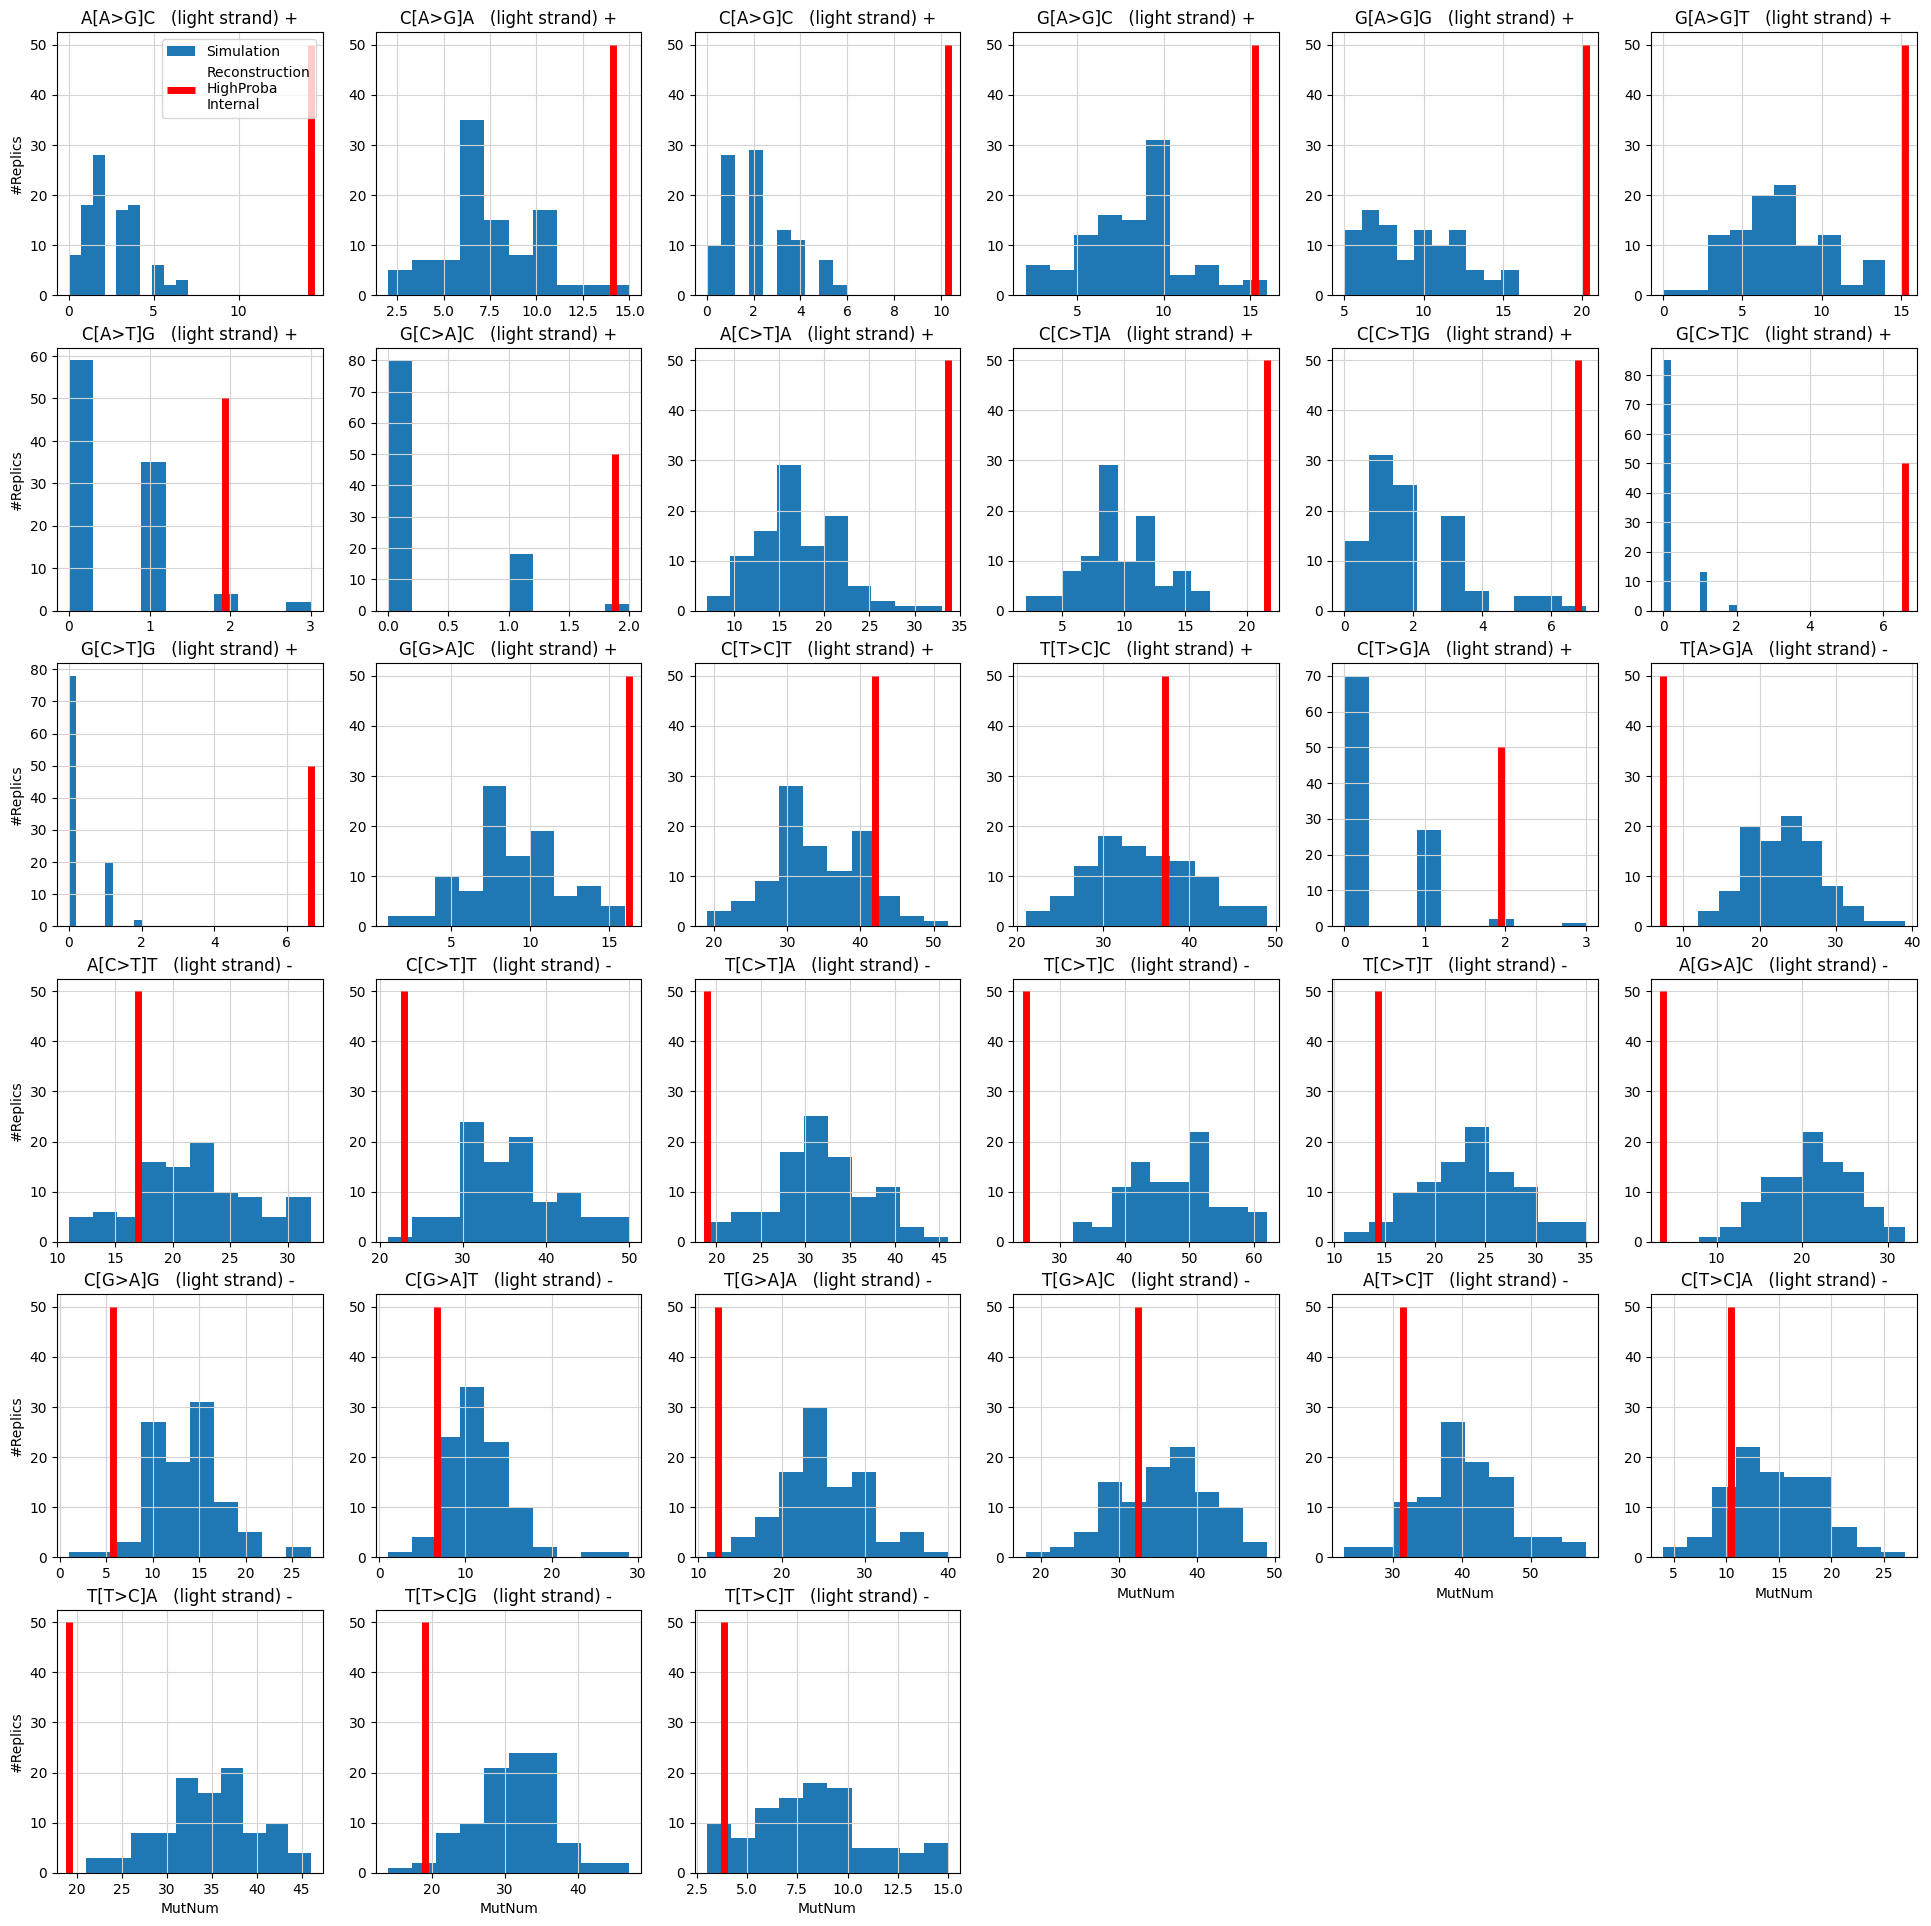

human_cox1


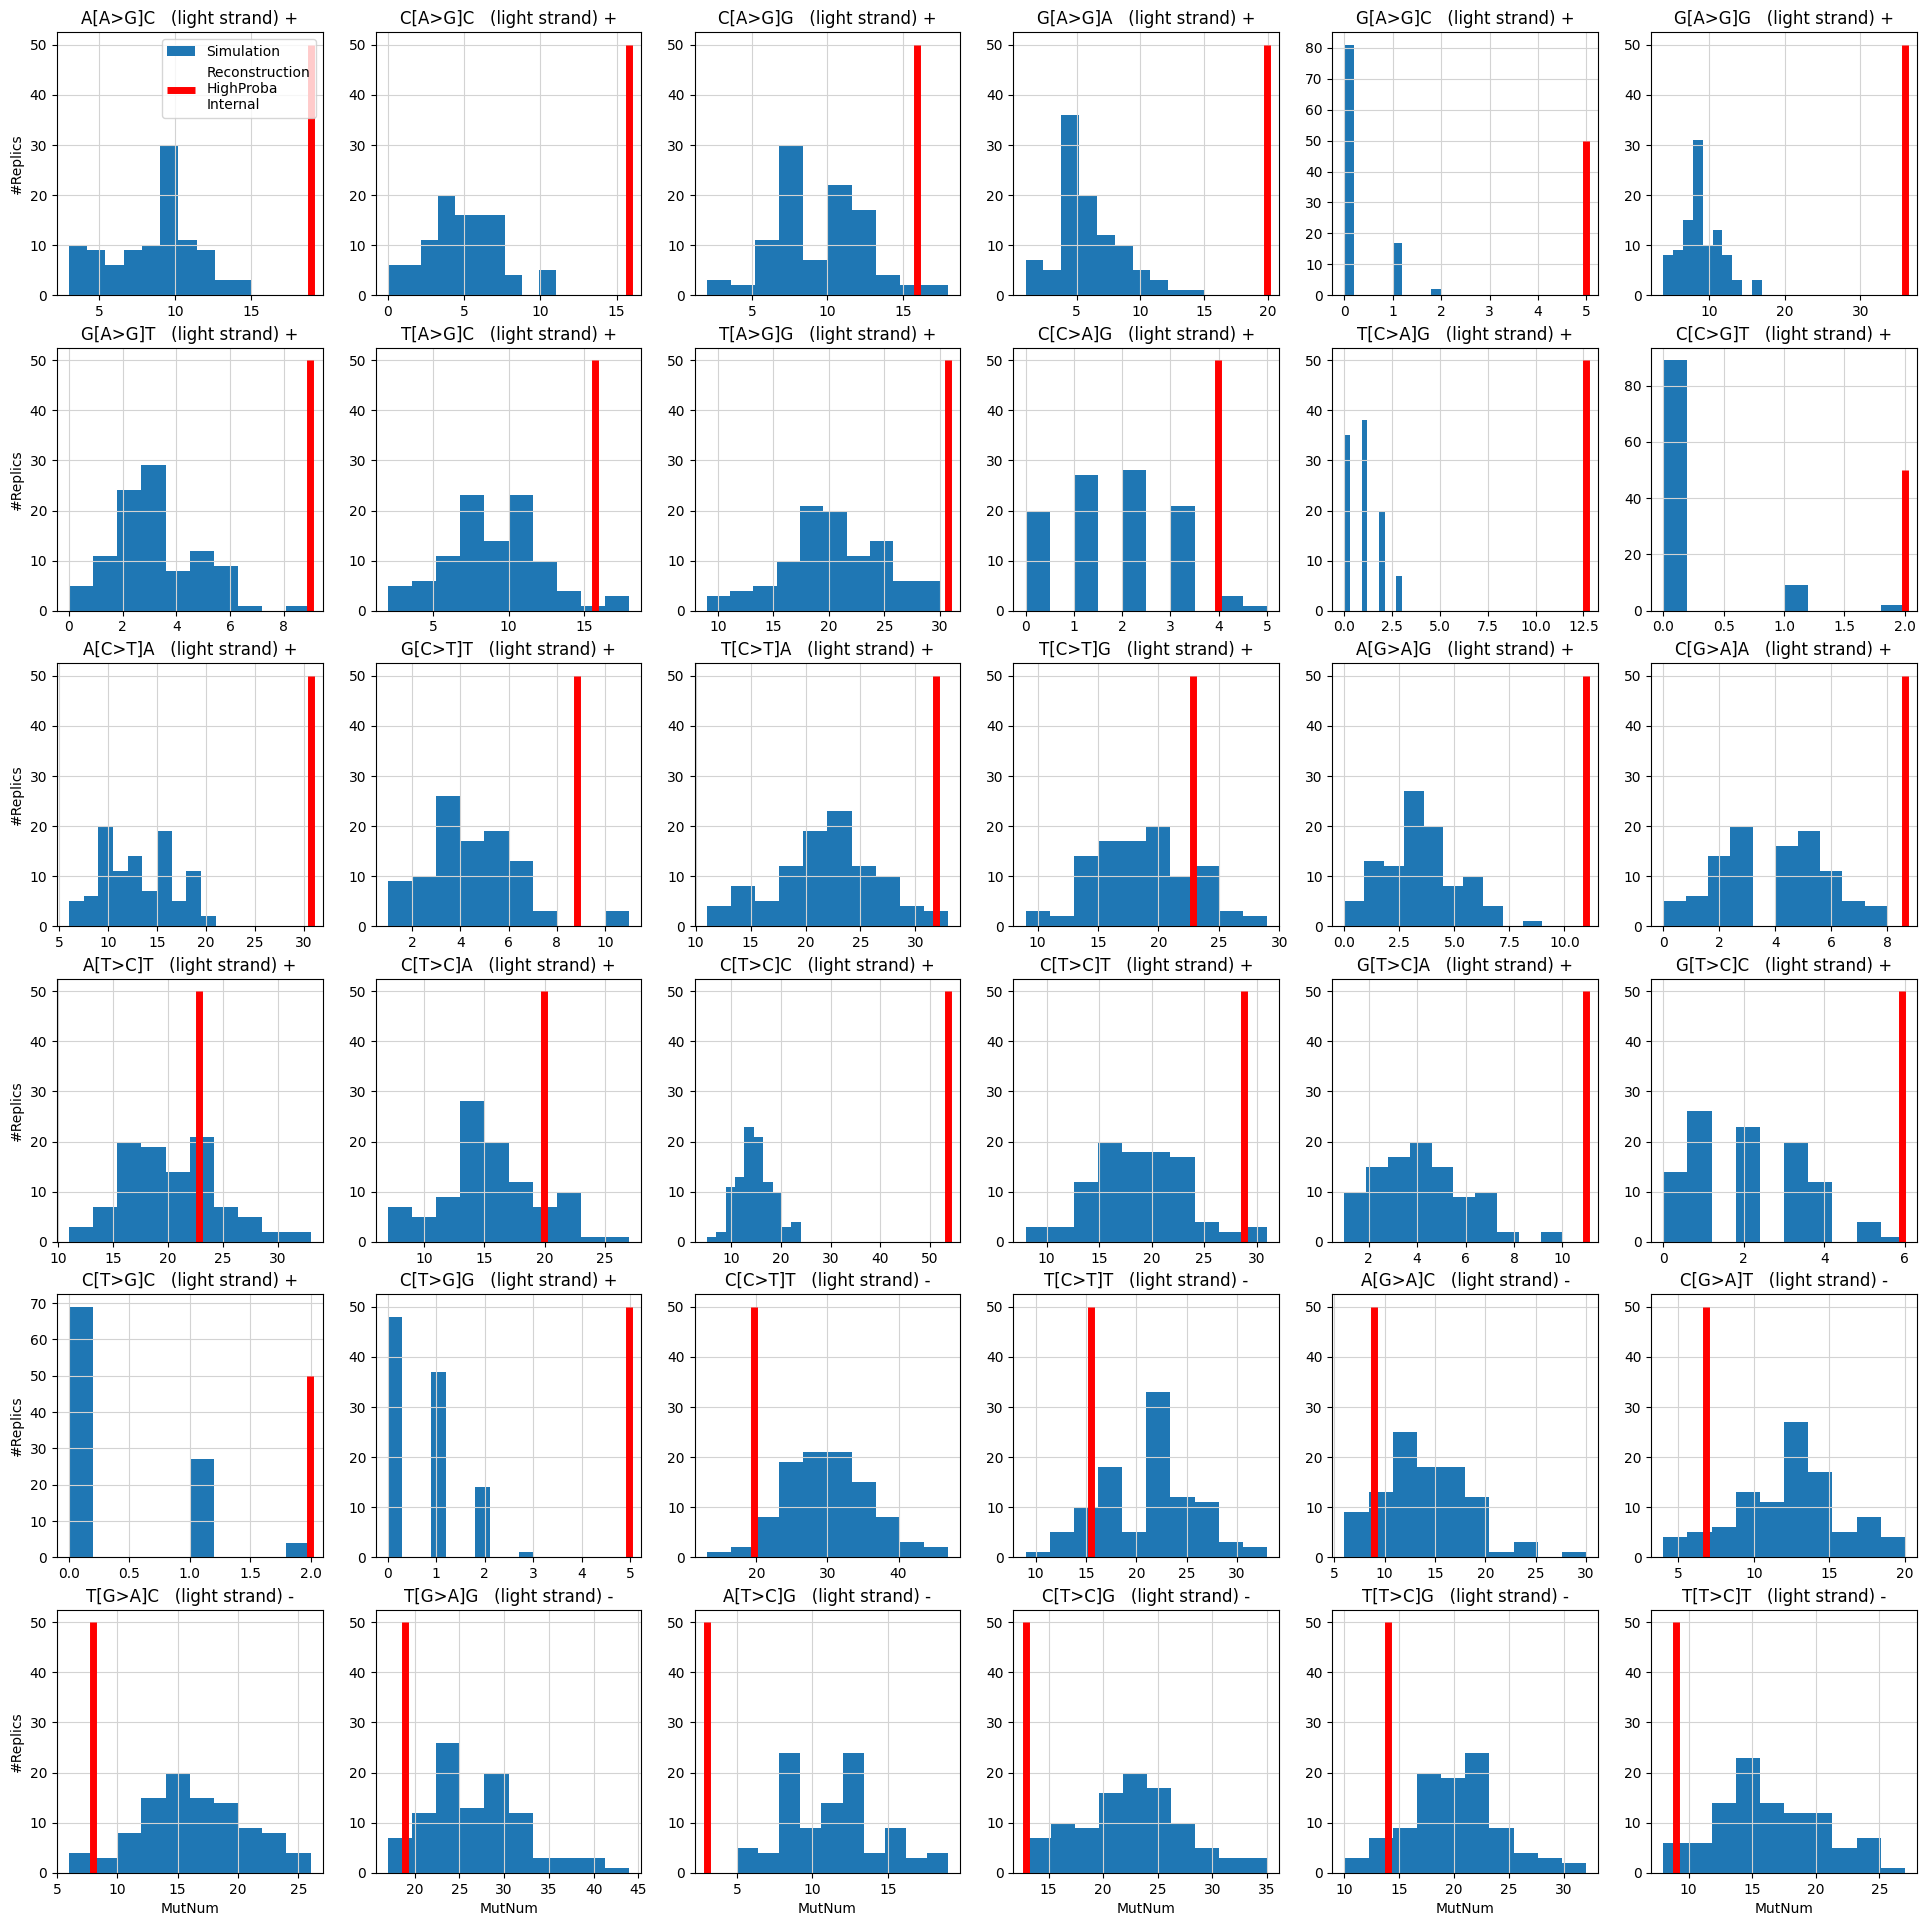

human_nd1


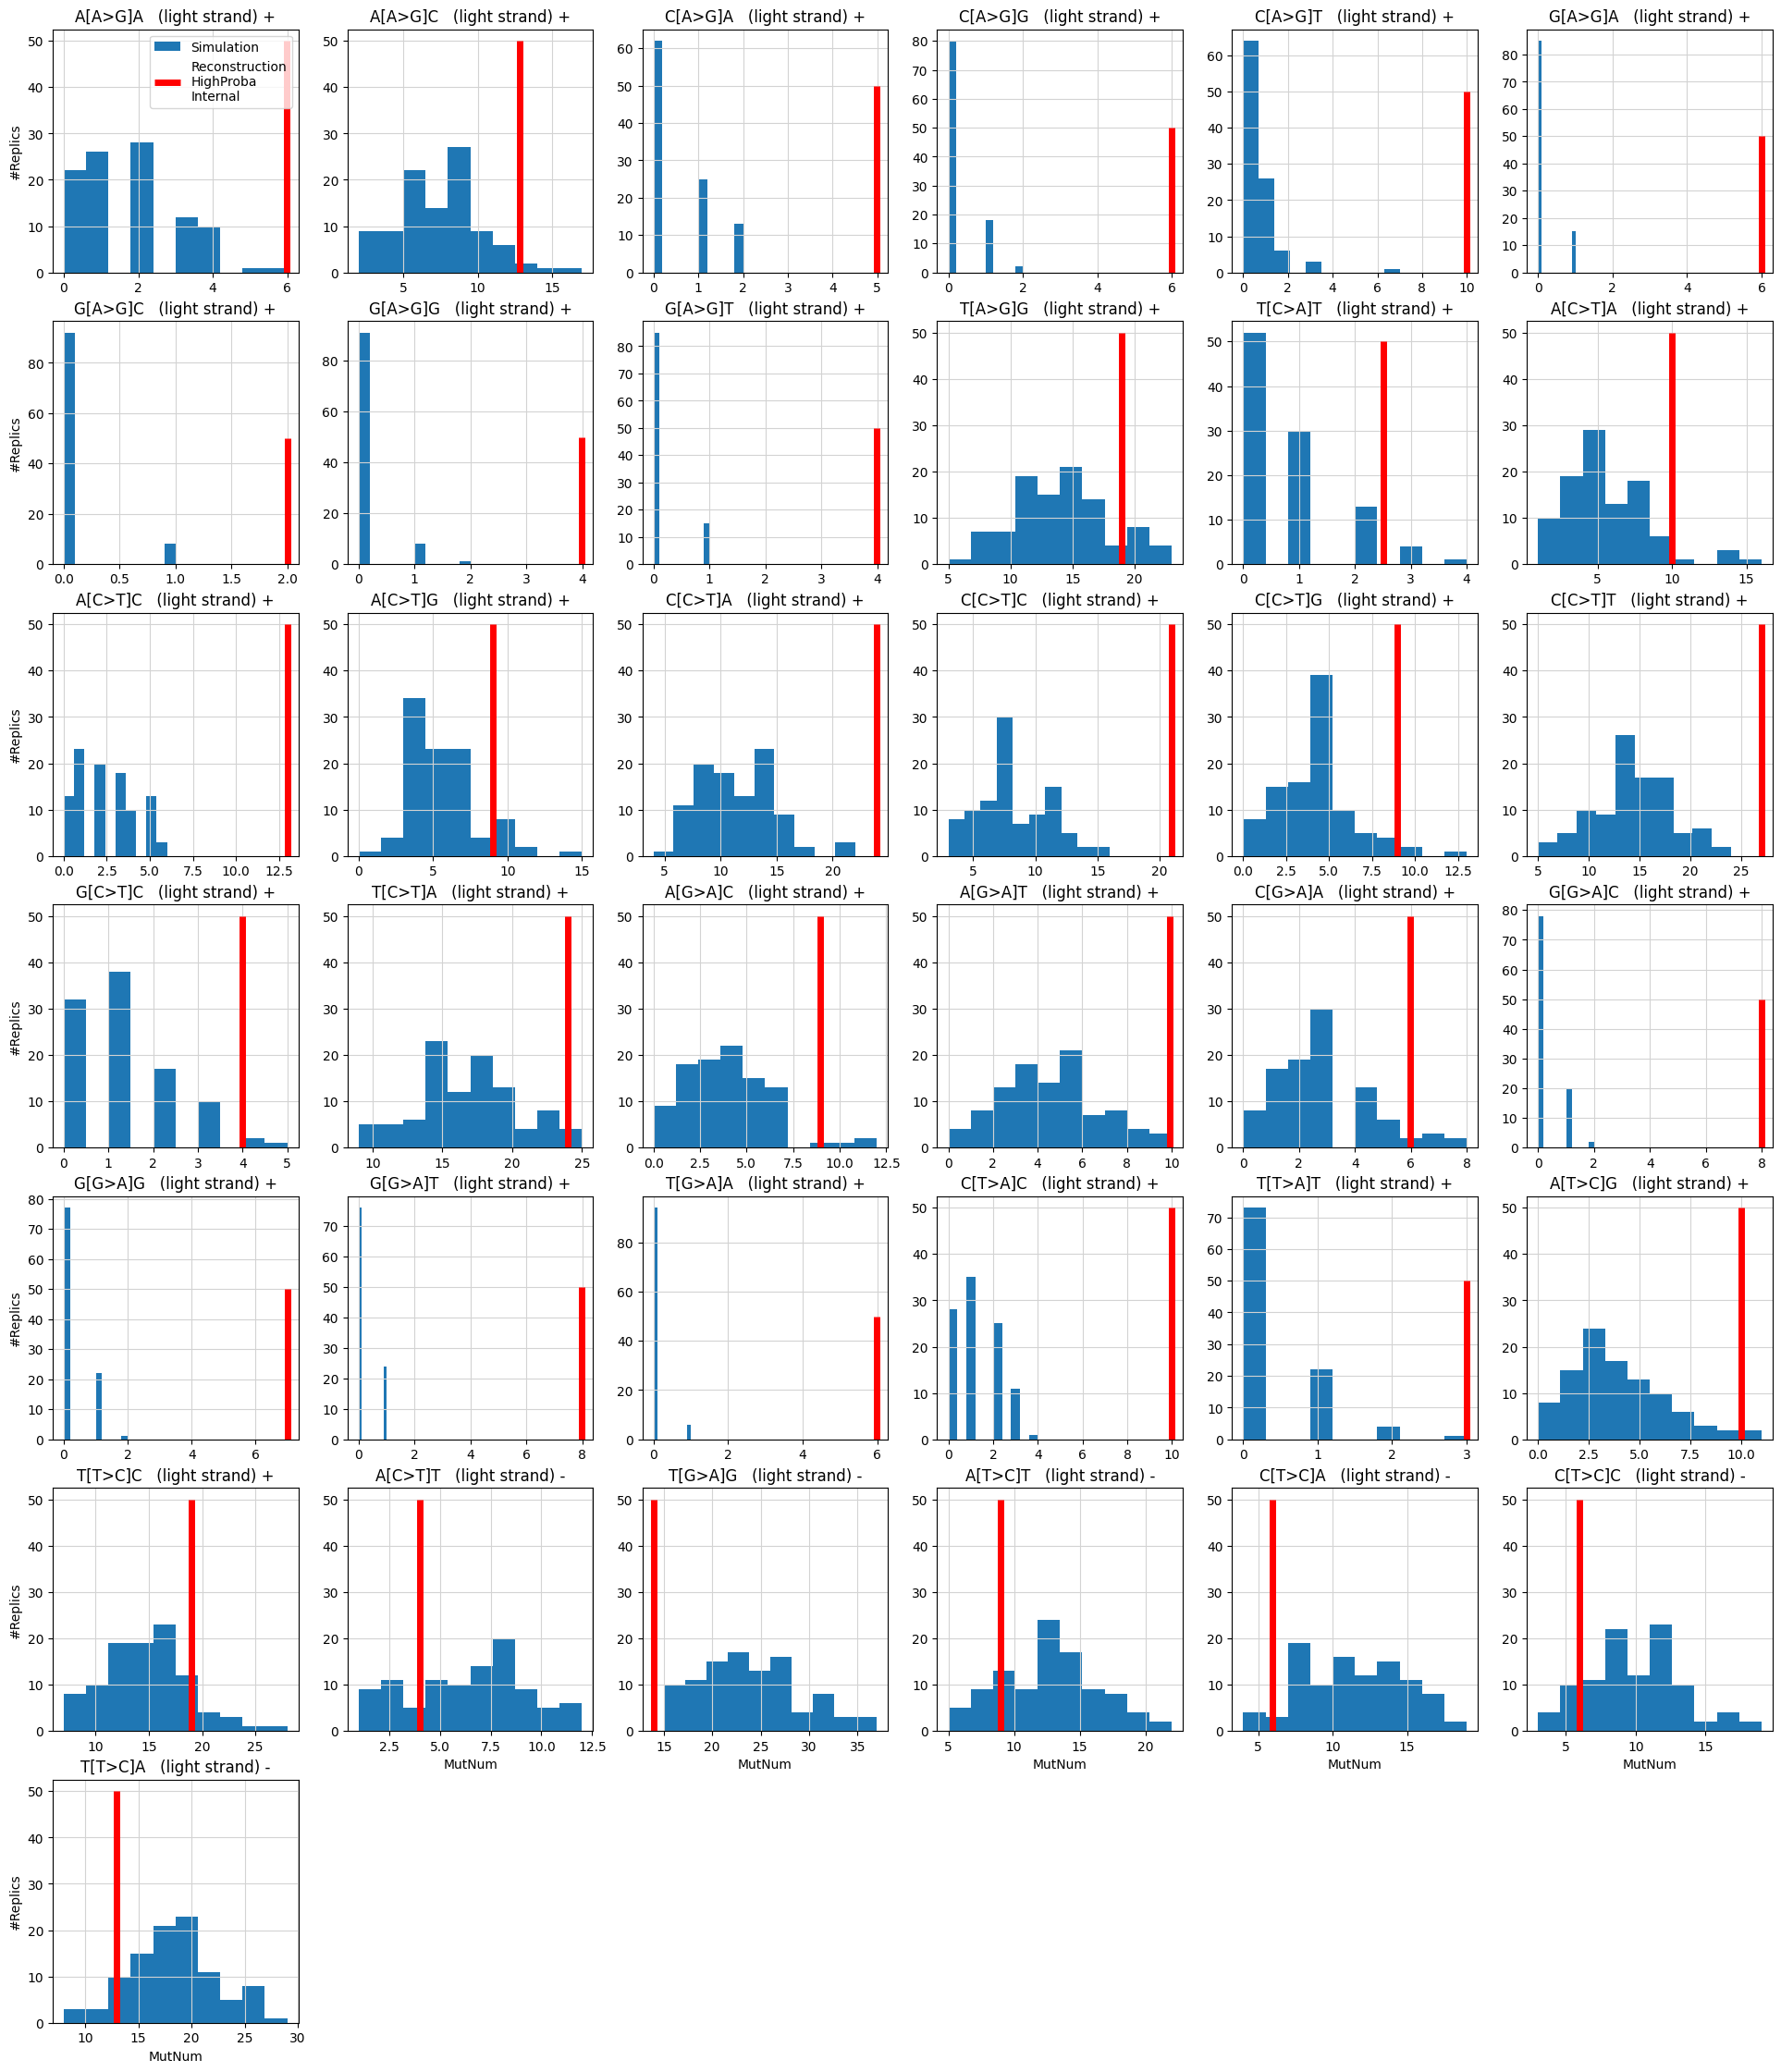

mouse_cytb


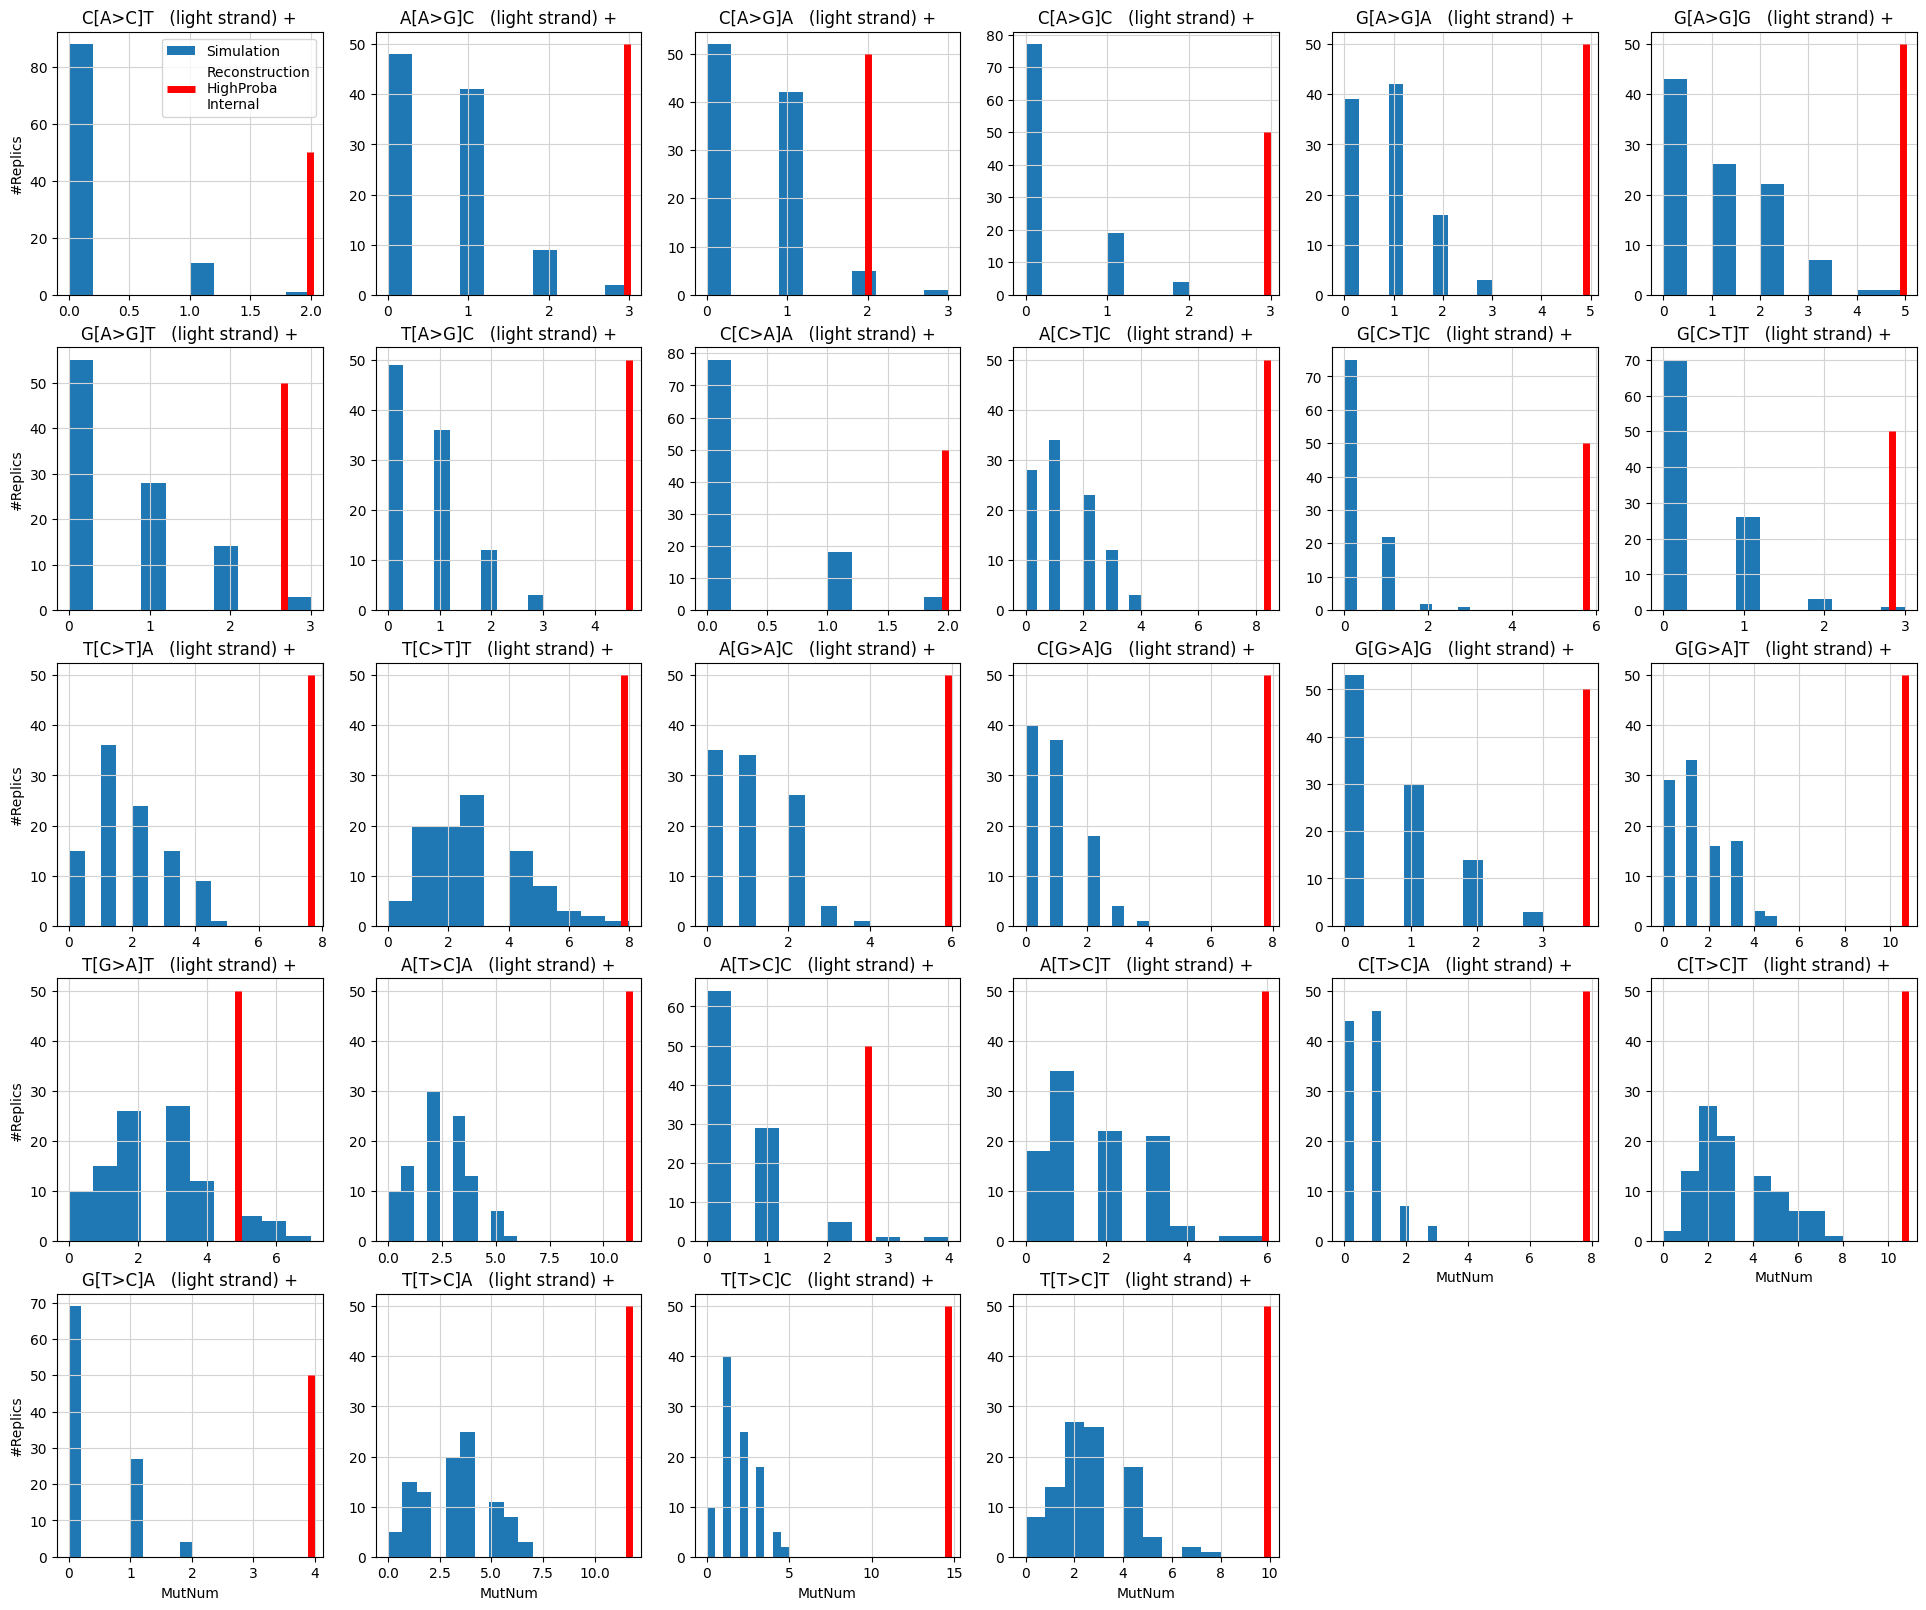

mouse_cox1


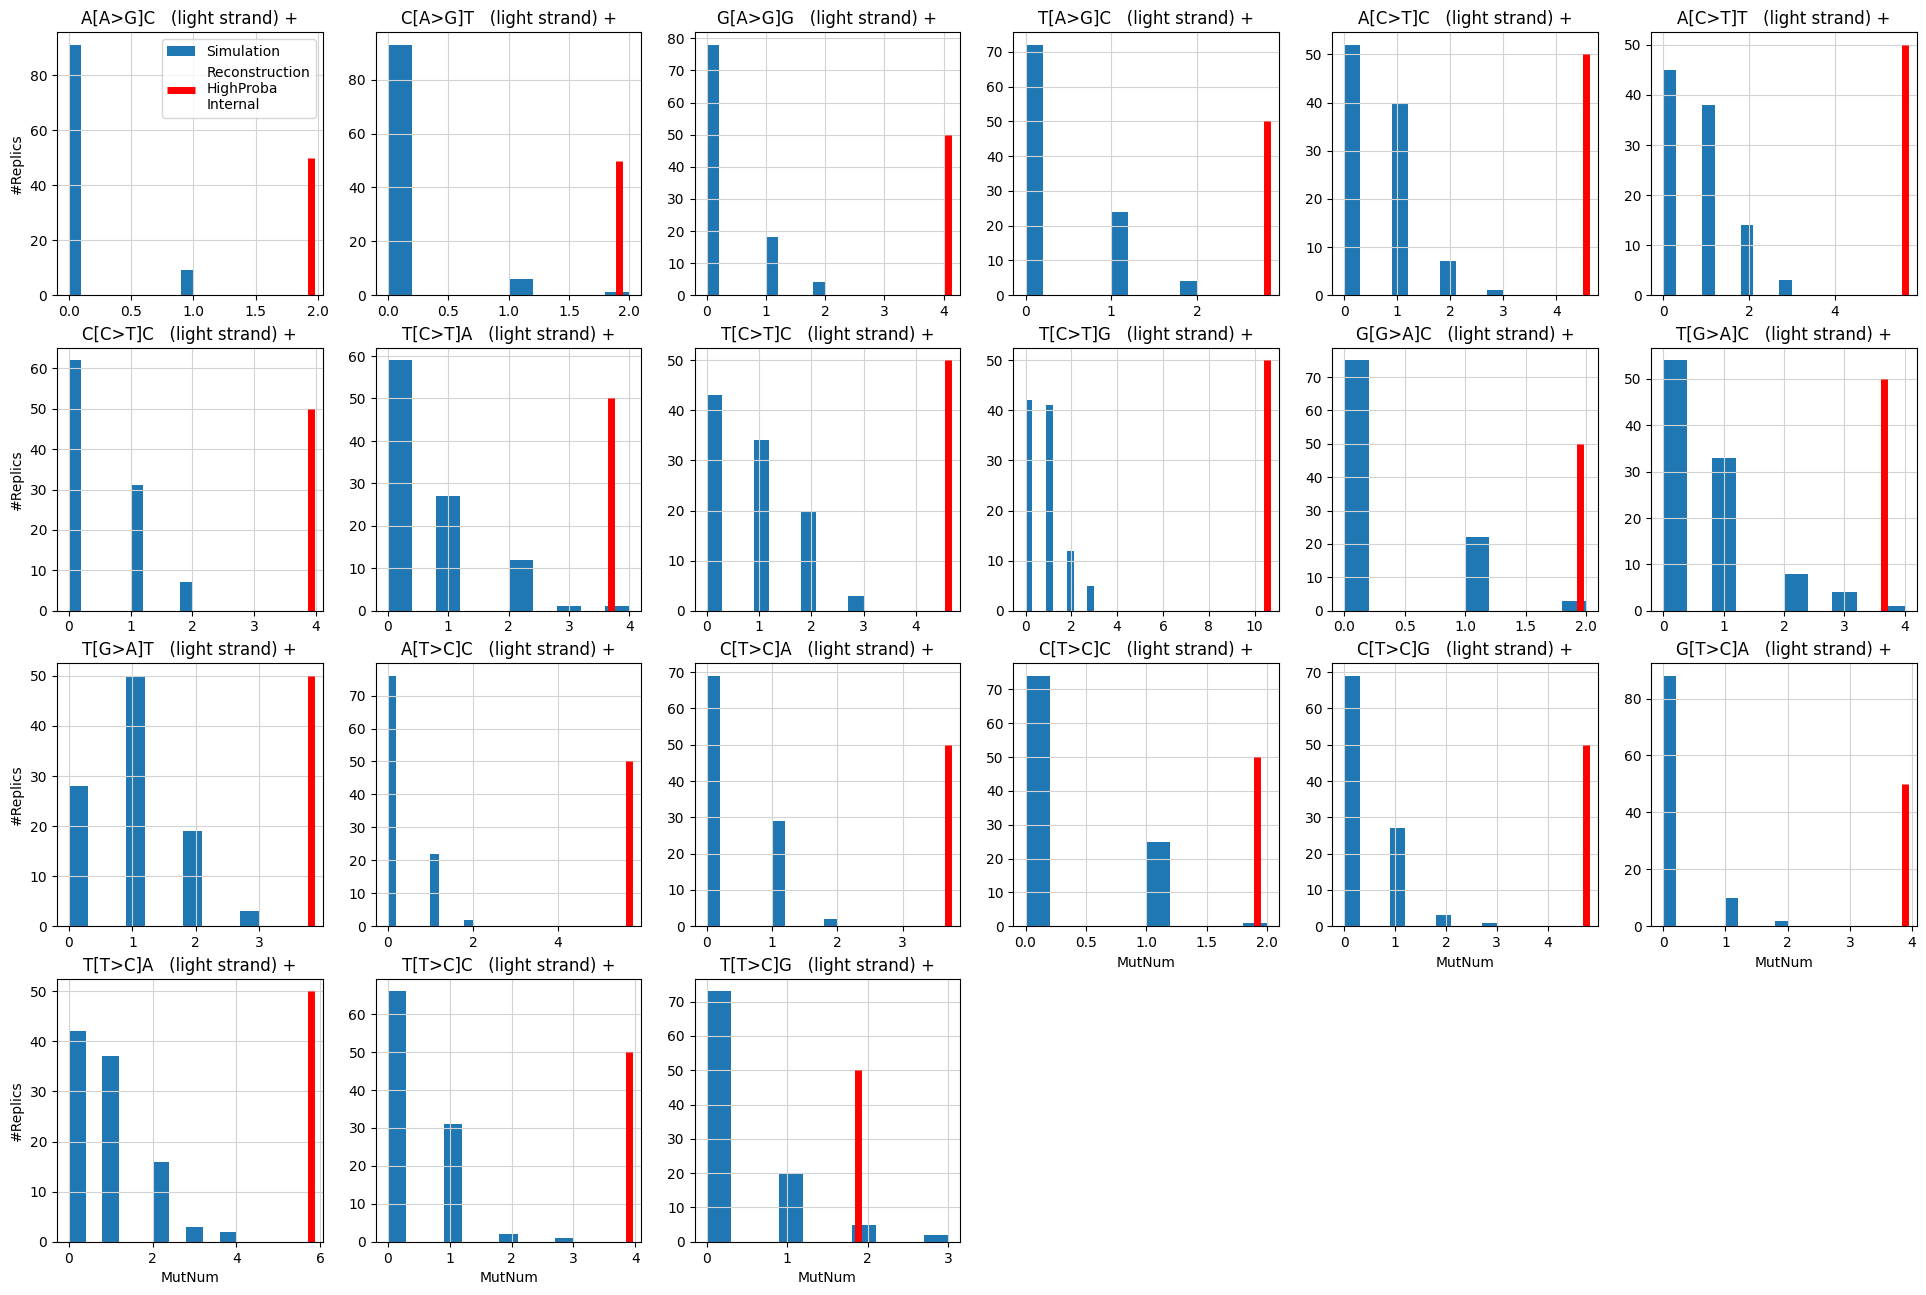

mouse_nd1


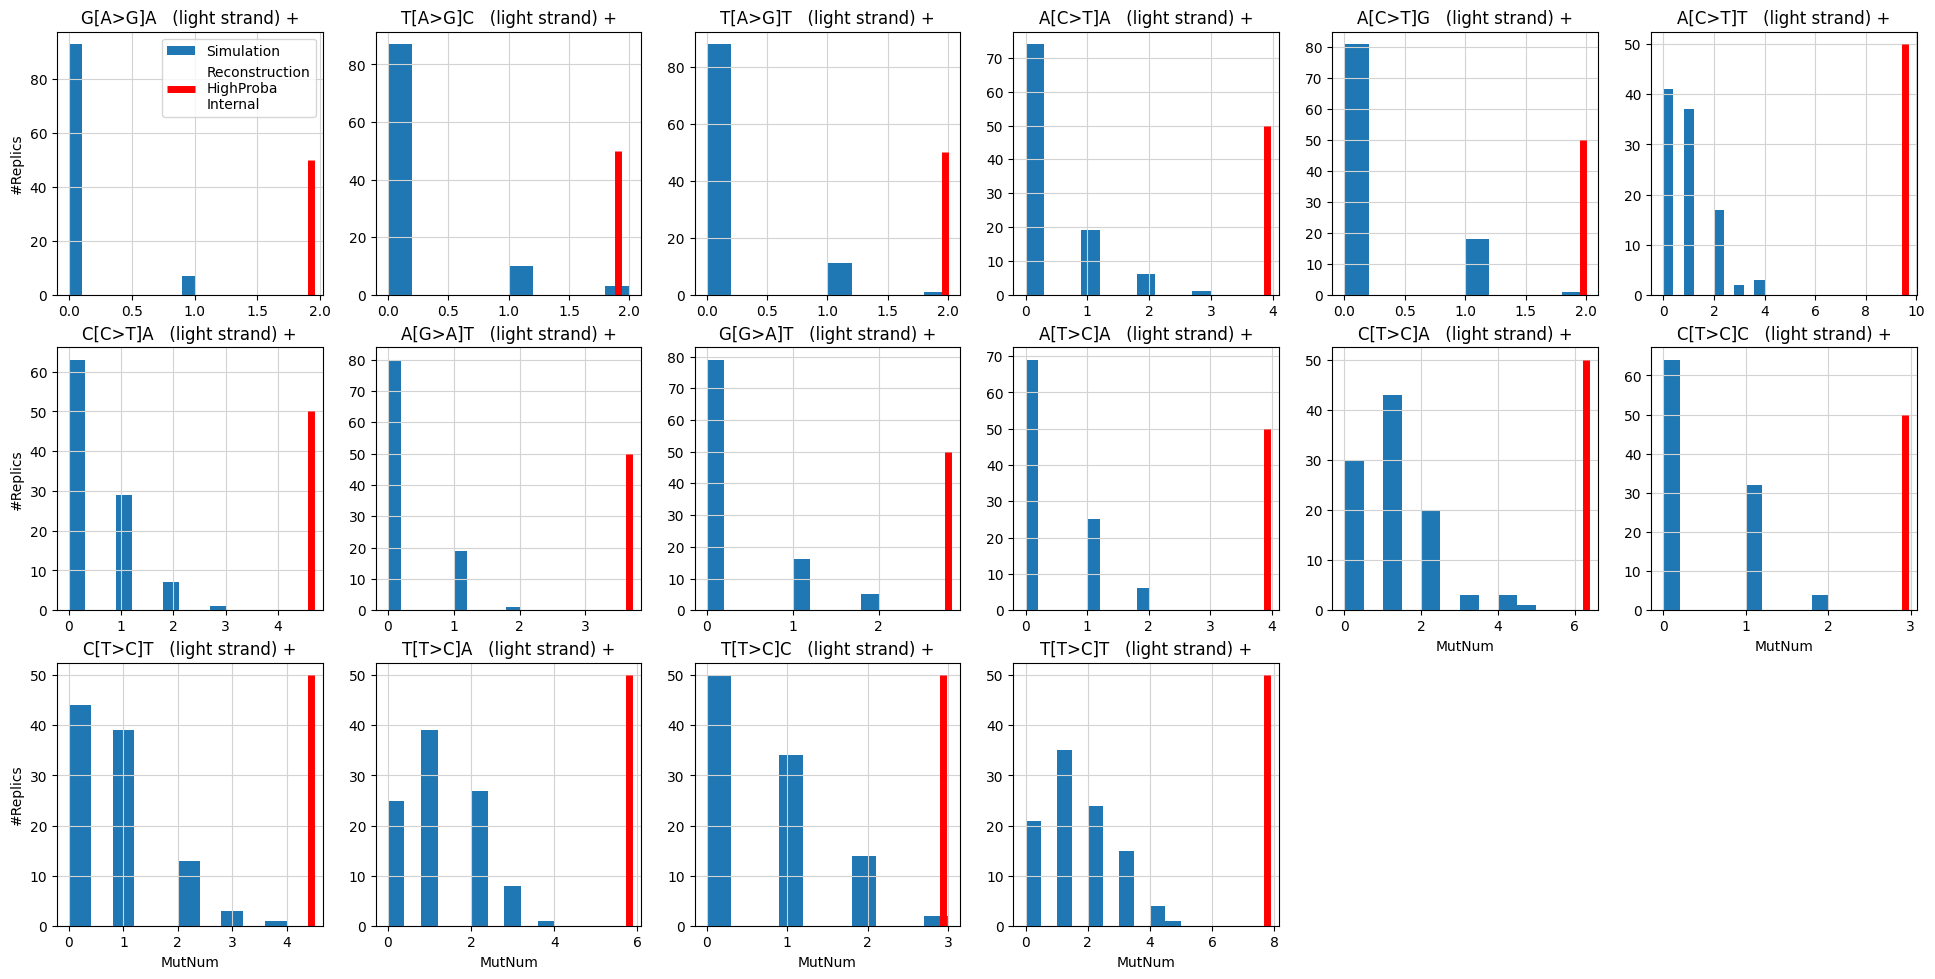

In [55]:
for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], 
                     [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    print(lbl)
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node"))
    ]
    high_proba_obs = high_proba_muts_syn.groupby("Mut").ProbaFull.sum().to_dict()

    nrows, ncols = 7, 6
    plt.figure(figsize=(ncols*4, nrows*4))
    smuts = [x for x in possible_sbs192 if x in data["muts_positive"]]
    effect = "+"
    i=0
    for i, sbs in enumerate(smuts, 1):
        sbs_distro = data["ms_sim192"][data["ms_sim192"].Mut == sbs]
        plt.subplot(nrows, ncols, i)
        plt.grid(color="lightgray")
        sbs_distro.ObsNum.hist(label="Simulation")
        plt.vlines([high_proba_obs[sbs]], 0, 50, "r", linewidth=5, label="Reconstruction\nHighProba\nInternal")
        plt.title(f"{sbs}   (light strand) {effect}")
        if i > len(data["diff_stats_filtered"]) - ncols:
            plt.xlabel("MutNum")
        if i % ncols == 1:
            plt.ylabel("#Replics")
        if i == 1:
            plt.legend()
    k = i + 1
    smuts = [x for x in possible_sbs192 if x in data["muts_negative"]]
    effect = "-"
    for i, sbs in enumerate(smuts, k):
        sbs_distro = data["ms_sim192"][data["ms_sim192"].Mut == sbs]
        plt.subplot(nrows, ncols, i)
        plt.grid(color="lightgray")
        sbs_distro.ObsNum.hist(label="Simulation")
        plt.vlines([high_proba_obs[sbs]], 0, 50, "r", linewidth=5, label="Reconstruction\nHighProba\nInternal")
        plt.title(f"{sbs}   (light strand) {effect}")
        if i > len(data["diff_stats_filtered"]) - ncols:
            plt.xlabel("MutNum")
        if i % ncols == 1:
            plt.ylabel("#Replics")
        if i == 1:
            plt.legend()

    # plt.savefig(f"../figures/sbs_significant_{lbl}.pdf", bbox_inches='tight')
    plt.show()


In [44]:
# save files for ET
# human_cytb["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/human_cytb_simulated_spectra.csv", index=False)
# human_nd1["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/human_nd1_simulated_spectra.csv", index=False)
# mouse_cytb["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/mouse_cytb_simulated_spectra.csv", index=False)
# mouse_nd1["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/mouse_nd1_simulated_spectra.csv", index=False)

# human_cytb["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/human_cytb_stats.csv")
# human_nd1["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/human_nd1_stats.csv")
# mouse_cytb["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/mouse_cytb_stats.csv")
# mouse_nd1["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/mouse_nd1_stats.csv")

In [33]:
for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    print(lbl)
    print("muts_positive:", list(data["muts_positive"]))
    print("muts_negative:", list(data["muts_negative"]))
    print()

human_cytb
muts_positive: []
muts_negative: []

human_cox1
muts_positive: []
muts_negative: []

human_nd1
muts_positive: []
muts_negative: []

mouse_cytb
muts_positive: []
muts_negative: []

mouse_cox1
muts_positive: []
muts_negative: []

mouse_nd1
muts_positive: []
muts_negative: []



### impose mutations effect on genome

In [137]:
for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node")) & 
        (data["mutations"].Mut.isin(list(data["muts_positive"]) + list(data["muts_negative"])))
    ].drop(["ProbaRef", "ProbaMut", "Gene", "AltAa"], axis=1)
    high_proba_muts_syn["Effect"] = high_proba_muts_syn.Mut.map(
        dict(**{x:"+" for x in data["muts_positive"]}, **{x:"-" for x in data["muts_negative"]})
    )
    high_proba_muts_syn.to_csv(f"../data/exposure/position_analysis/observed_mutations_with_effect_{lbl}.csv", index=False)


In [111]:
# fout = open("../data/exposure/consensus_labels_fr_syn2.txt", "w")
# for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
#     fout.write(">"+lbl+"\n")
#     fout.write(data['consensus']+"\n")
#     muts_plus = data["mutations"][data["mutations"].Mut.isin(data["muts_positive"])]
#     muts_minus = data["mutations"][data["mutations"].Mut.isin(data["muts_negative"])]

#     muts_plus_est = muts_plus[muts_plus.Label >= 1].groupby(["Mut", "PosInGene"]).ProbaFull.sum()
#     muts_minus_est = muts_minus[muts_minus.Label >= 1].groupby(["Mut", "PosInGene"]).ProbaFull.sum()

#     pos_plus  = set(muts_plus_est[muts_plus_est > 0.5].reset_index().PosInGene.values)
#     pos_minus = set(muts_minus_est[muts_minus_est > 0.5].reset_index().PosInGene.values)

#     for pos in range(1, len(data['consensus'])+1):
#         if pos in pos_plus:
#             fout.write("+")
#         elif pos in pos_minus:
#             fout.write("-")
#         else:
#             fout.write(" ")
#     fout.write("\n\n")

# fout.close()

## Sample syn mutations

### Uniform

In [5]:
coda = CodonAnnotation(2)

In [6]:
def sample_mutations(muts, n):
    positions = np.random.choice(muts.Pos.unique(), n, replace=True)
    muts_sample1 = muts[muts.Pos.isin(positions)].groupby("Pos").sample()
    c = Counter(positions)
    samples_up1 = []
    for pos, k in c.most_common(len(positions)):
        if k > 1:
            d = muts[muts.Pos == pos]
            samples_up1.append(d.sample(k - 1, replace=True))
        else:
            break
    if len(samples_up1):
        muts_sample2 = pd.concat(samples_up1)
        total_samples = pd.concat([muts_sample1, muts_sample2])
    else:
        total_samples = muts_sample1
    assert len(total_samples) == n
    return total_samples

In [7]:
nsamples = 10

for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    emuts = coda.collect_exp_muts(data["consensus"])
    emuts = emuts[emuts.Pos.isin(data["var_pos"])]
    n = round(data["mutations"][
        (data["mutations"].Label > 0) & 
        (data["mutations"].AltNode.str.startswith("Node")) & 
        (data["mutations"].ProbaFull > 0.3)
    ].ProbaFull.sum())
    samples = []
    for i in range(nsamples):
        s = sample_mutations(emuts, n)
        s["Sample"] = i + 1
        samples.append(s)
    samples_df = pd.concat(samples)
    data["samples"] = samples_df
    # samples_df.to_csv(f"../data/exposure/position_analysis/mut_samples_{lbl}.csv", index=False)

### Non-uniform, spectra-specific sampling

In [37]:
from scipy.stats import multinomial

coda = CodonAnnotation(2)

In [39]:
md = multinomial(100, [0.1, 0.4, 0.3, 0.195, 0.005])
md.rvs(3)

array([[11, 43, 27, 19,  0],
       [ 9, 39, 28, 21,  3],
       [13, 43, 31, 12,  1]])

In [110]:
def sample_sbs_counts(muts, sbs_counts: dict):
    sbs_samples = []
    for sbs, cnt in sbs_counts.items():
        if cnt < 1:
            continue
        cur_muts = muts[muts["MutBase"] == sbs]
        if len(cur_muts):
            s = cur_muts.sample(cnt, replace=True)
            sbs_samples.append(s)

    return pd.concat(sbs_samples)


nsamples = 1000

for lbl, data in zip(['human_cytb', 'human_cox1', 'human_nd1', 'mouse_cytb', 'mouse_cox1', 'mouse_nd1'], [human_cytb, human_cox1, human_nd1, mouse_cytb, mouse_cox1, mouse_nd1]):
    emuts = coda.collect_exp_muts(data["consensus"])
    emuts = emuts[emuts.Pos.isin(data["var_pos"])]
    cur_obs_muts = data["mutations"][
        (data["mutations"].Label > 0) & 
        (data["mutations"].AltNode.str.startswith("Node")) & 
        (data["mutations"].ProbaFull > 0.3)
    ]
    n = round(cur_obs_muts.ProbaFull.sum())
    cur_obs_muts["MutBase"] = cur_obs_muts.Mut.str.slice(2, 5)
    spectra12 = cur_obs_muts.groupby("MutBase").ProbaFull.sum()
    spectra12 = (spectra12 / spectra12.sum()).to_dict()
    spectra12 = {sbs: spectra12.get(sbs, 0.001) for sbs in possible_sbs12}
    spectra12 = {sbs: p / sum(spectra12.values()) for sbs, p in spectra12.items()}

    assert len(spectra12) == 12
    sbs_types, probas = spectra12.keys(), list(spectra12.values())
    md = multinomial(n, probas)
    samples = []
    for i, sbs_counts in enumerate(md.rvs(nsamples)):
        sbs_counts = dict(zip(sbs_types, sbs_counts))
        s = sample_sbs_counts(emuts, sbs_counts)
        s["Sample"] = i + 1
        samples.append(s)
    samples_df = pd.concat(samples)
    data["samples"] = samples_df
    samples_df.to_csv(f"../data/exposure/position_analysis/mut_samples_spectra_based_{lbl}.csv", index=False)
    # break